In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.ESN_v5_AR import ESN as AR_RNN_ESN
from tools.AEESN_AR_v1 import AR_AERNN_ESN
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2022-12-27 20:34:18.751837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-27 20:34:18.752281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 20:34:18.809216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 20:34:18.809619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 20:34:18.809954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 20:34:18.810353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_032'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_014'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in AR_RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        normalization_type = params_AR_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in AR_RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    covmat_lmda = tparams_dict['covmat_lmda']
    try:
        lambda_reg = tparams_dict['lambda_reg']
    except:
        lambda_reg = 1e-6
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_032
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

In [16]:
all_data.shape

(500026, 64)

# Autoencoder

In [17]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [18]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# ESN

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_ESN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [20]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [2e-5],
        [1e-5],
        [2e-6],
        [1e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
    ]
    patience = [
        [100],
        [100],
        [100],
        [100],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    train_alpha = [False]*3
    train_omega_in = [False]*3
    train_rho_res = [False]*3
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
        'lambda_reg':lambda_reg,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [21]:
rnn_kwargs = {}
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
    
    rnn_kwargs = {
        'train_alpha':train_alpha,
        'train_omega_in':train_omega_in,
        'train_rho_res':train_rho_res,
    }



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 0.0067 - mse: 7.5987e-04 - NMSE: 0.0068 - covmat_fro_loss: 3.0927e-04 - global_gradnorm: 1.4043 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 0m 44.6s

Epoch 1: val_NMSE improved from inf to 0.00676, saving model to /home/rkaushik/Documents/Thesis/

Epoch 7/1000
76/76 [==============================] - ETA: 0s - loss: 0.0053 - mse: 5.8860e-04 - NMSE: 0.0053 - covmat_fro_loss: 2.7758e-04 - global_gradnorm: 1.1153 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 4m 1.7s

Epoch 7: val_NMSE improved from 0.00595 to 0.00587, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 434ms/step - loss: 0.0053 - mse: 5.8860e-04 - NMSE: 0.0053 - covmat_fro_loss: 2.7747e-04 - global_gradnorm: 1.1160 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.000

76/76 [==============================] - ETA: 0s - loss: 0.0049 - mse: 5.3554e-04 - NMSE: 0.0048 - covmat_fro_loss: 2.6646e-04 - global_gradnorm: 1.0543 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 7m 18.3s

Epoch 13: val_NMSE did not improve from 0.00534
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0049 - mse: 5.3554e-04 - NMSE: 0.0048 - covmat_fro_loss: 2.6663e-04 - global_gradnorm: 1.0568 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0053 - val_mse: 5.9375e-04 - val_NMSE: 0.0053 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnor

Epoch 20/1000
76/76 [==============================] - ETA: 0s - loss: 0.0045 - mse: 4.9420e-04 - NMSE: 0.0044 - covmat_fro_loss: 2.5802e-04 - global_gradnorm: 0.9878 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 11m 6.3s

Epoch 20: val_NMSE did not improve from 0.00502
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0045 - mse: 4.9420e-04 - NMSE: 0.0044 - covmat_fro_loss: 2.5807e-04 - global_gradnorm: 0.9890 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0051 - val_mse: 5.6335e-04 - val_NMSE: 0.0051 - val_covmat_fro_loss: 0.0000e+00 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 425ms/step - loss: 0.0043 - mse: 4.6676e-04 - NMSE: 0.0042 - covmat_fro_loss: 2.5162e-04 - global_gradnorm: 0.9150 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0048 - val_mse: 5.2547e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_rho_res_1: 0.8000 - val_rho_res_2: 0.8000 - val_alpha_0: 1.0000 - val_alpha_1: 1.0000 - val_alpha_2: 1.0000 - val_omega_in_0: 1.0000 - val_omega_in_1: 1.0000 - val_omega_in_2: 1.0000
Epoch 27/1000
76/76 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.5704e-04 - NMSE: 0.0041 - covmat_fro_loss: 2.4902e-04 - global_gradnorm: 0.9032 - rho_res

Epoch 33/1000
76/76 [==============================] - ETA: 0s - loss: 0.0040 - mse: 4.3427e-04 - NMSE: 0.0039 - covmat_fro_loss: 2.4375e-04 - global_gradnorm: 0.8642 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 18m 8.8s

Epoch 33: val_NMSE did not improve from 0.00455
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0040 - mse: 4.3427e-04 - NMSE: 0.0039 - covmat_fro_loss: 2.4411e-04 - global_gradnorm: 0.8653 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0046 - val_mse: 5.0939e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_

76/76 [==============================] - ETA: 0s - loss: 0.0038 - mse: 4.0801e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.3700e-04 - global_gradnorm: 0.8045 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 21m 24.6s

Epoch 39: val_NMSE did not improve from 0.00435
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 425ms/step - loss: 0.0038 - mse: 4.0801e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.3710e-04 - global_gradnorm: 0.8048 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0044 - val_mse: 4.8400e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradno

Epoch 46/1000
76/76 [==============================] - ETA: 0s - loss: 0.0037 - mse: 3.9876e-04 - NMSE: 0.0036 - covmat_fro_loss: 2.3489e-04 - global_gradnorm: 0.8011 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 25m 12.0s

Epoch 46: val_NMSE did not improve from 0.00413
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0037 - mse: 3.9876e-04 - NMSE: 0.0036 - covmat_fro_loss: 2.3496e-04 - global_gradnorm: 0.7992 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0042 - val_mse: 4.6092e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val

Epoch 53/1000
76/76 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.7628e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.2905e-04 - global_gradnorm: 0.7475 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 28m 58.6s

Epoch 53: val_NMSE did not improve from 0.00403
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0035 - mse: 3.7628e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.2912e-04 - global_gradnorm: 0.7472 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0041 - val_mse: 4.4936e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val

Epoch 60/1000
76/76 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.6335e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2571e-04 - global_gradnorm: 0.7351 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 32m 46.0s

Epoch 60: val_NMSE did not improve from 0.00391
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0034 - mse: 3.6335e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2547e-04 - global_gradnorm: 0.7352 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0041 - val_mse: 4.4277e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val

Epoch 67/1000
76/76 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.4887e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.2167e-04 - global_gradnorm: 0.6935 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 36m 32.8s

Epoch 67: val_NMSE did not improve from 0.00389
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0033 - mse: 3.4887e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.2186e-04 - global_gradnorm: 0.6944 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0041 - val_mse: 4.4505e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val

Epoch 74/1000
76/76 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.4190e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.1963e-04 - global_gradnorm: 0.7021 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 40m 19.8s

Epoch 74: val_NMSE improved from 0.00385 to 0.00376, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 431ms/step - loss: 0.0032 - mse: 3.4190e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.1959e-04 - global_gradnorm: 0.7015 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1

Epoch 81/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.2980e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1610e-04 - global_gradnorm: 0.6637 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 44m 7.1s

Epoch 81: val_NMSE did not improve from 0.00364
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 425ms/step - loss: 0.0031 - mse: 3.2980e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1625e-04 - global_gradnorm: 0.6631 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0039 - val_mse: 4.2570e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_

Epoch 88/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.2589e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1492e-04 - global_gradnorm: 0.6810 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 47m 53.8s

Epoch 88: val_NMSE improved from 0.00364 to 0.00362, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0031 - mse: 3.2589e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1496e-04 - global_gradnorm: 0.6799 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0030 - mse: 3.1645e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1233e-04 - global_gradnorm: 0.6583 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0038 - val_mse: 4.1040e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_rho_res_1: 0.8000 - val_rho_res_2: 0.8000 - val_alpha_0: 1.0000 - val_alpha_1: 1.0000 - val_alpha_2: 1.0000 - val_omega_in_0: 1.0000 - val_omega_in_1: 1.0000 - val_omega_in_2: 1.0000
Epoch 95/1000
76/76 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.1046e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1019e-04 - global_gradnorm: 0.6257 - rho_res

Epoch 101/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.0433e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0854e-04 - global_gradnorm: 0.6153 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 54m 56.8s

Epoch 101: val_NMSE did not improve from 0.00347
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0029 - mse: 3.0433e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0868e-04 - global_gradnorm: 0.6153 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0037 - val_mse: 3.9479e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 108/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.9197e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0472e-04 - global_gradnorm: 0.5770 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 58m 44.1s

Epoch 108: val_NMSE did not improve from 0.00339
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0028 - mse: 2.9197e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0484e-04 - global_gradnorm: 0.5766 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0035 - val_mse: 3.7702e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 115/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.9290e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0527e-04 - global_gradnorm: 0.6139 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 2m 31.6s

Epoch 115: val_NMSE did not improve from 0.00338
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 428ms/step - loss: 0.0028 - mse: 2.9290e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0533e-04 - global_gradnorm: 0.6137 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0035 - val_mse: 3.7821e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 122/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.8602e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0293e-04 - global_gradnorm: 0.5979 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 6m 19.9s

Epoch 122: val_NMSE did not improve from 0.00331
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0028 - mse: 2.8602e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0292e-04 - global_gradnorm: 0.5988 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0035 - val_mse: 3.7022e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 129/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.7884e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0047e-04 - global_gradnorm: 0.5840 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 10m 7.9s

Epoch 129: val_NMSE did not improve from 0.00325
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0027 - mse: 2.7884e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0044e-04 - global_gradnorm: 0.5836 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0035 - val_mse: 3.7903e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0026 - mse: 2.7117e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9810e-04 - global_gradnorm: 0.5467 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0033 - val_mse: 3.5317e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_rho_res_1: 0.8000 - val_rho_res_2: 0.8000 - val_alpha_0: 1.0000 - val_alpha_1: 1.0000 - val_alpha_2: 1.0000 - val_omega_in_0: 1.0000 - val_omega_in_1: 1.0000 - val_omega_in_2: 1.0000
Epoch 136/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.7499e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9942e-04 - global_gradnorm: 0.5741 - rho_re

Epoch 142/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7041e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9795e-04 - global_gradnorm: 0.5568 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 17m 10.8s

Epoch 142: val_NMSE improved from 0.00316 to 0.00315, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 433ms/step - loss: 0.0026 - mse: 2.7041e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9807e-04 - global_gradnorm: 0.5572 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 432ms/step - loss: 0.0026 - mse: 2.6225e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9546e-04 - global_gradnorm: 0.5291 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0032 - val_mse: 3.4357e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_rho_res_1: 0.8000 - val_rho_res_2: 0.8000 - val_alpha_0: 1.0000 - val_alpha_1: 1.0000 - val_alpha_2: 1.0000 - val_omega_in_0: 1.0000 - val_omega_in_1: 1.0000 - val_omega_in_2: 1.0000
Epoch 149/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6107e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9478e-04 - global_gradnorm: 0.5296 - rho_re

Epoch 155/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5949e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9433e-04 - global_gradnorm: 0.5338 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 24m 14.2s

Epoch 155: val_NMSE did not improve from 0.00306
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0025 - mse: 2.5949e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9436e-04 - global_gradnorm: 0.5344 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0033 - val_mse: 3.5144e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 162/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5569e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9328e-04 - global_gradnorm: 0.5321 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 28m 1.4s

Epoch 162: val_NMSE did not improve from 0.00306
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0025 - mse: 2.5569e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9328e-04 - global_gradnorm: 0.5326 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0032 - val_mse: 3.4063e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 169/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5081e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9138e-04 - global_gradnorm: 0.5219 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 31m 49.6s

Epoch 169: val_NMSE did not improve from 0.00300
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0025 - mse: 2.5081e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9159e-04 - global_gradnorm: 0.5212 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0032 - val_mse: 3.3994e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 176/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4312e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8874e-04 - global_gradnorm: 0.5043 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 35m 37.7s

Epoch 176: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0024 - mse: 2.4312e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8879e-04 - global_gradnorm: 0.5054 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0032 - val_mse: 3.3586e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 183/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4568e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8957e-04 - global_gradnorm: 0.5160 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 39m 25.1s

Epoch 183: val_NMSE did not improve from 0.00292
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0024 - mse: 2.4568e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8942e-04 - global_gradnorm: 0.5153 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0031 - val_mse: 3.3182e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 190/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4190e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8828e-04 - global_gradnorm: 0.5084 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 43m 12.9s

Epoch 190: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0024 - mse: 2.4190e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8818e-04 - global_gradnorm: 0.5074 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0031 - val_mse: 3.2419e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 197/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3206e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8477e-04 - global_gradnorm: 0.4733 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 47m 1.2s

Epoch 197: val_NMSE improved from 0.00285 to 0.00282, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 434ms/step - loss: 0.0023 - mse: 2.3206e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8483e-04 - global_gradnorm: 0.4742 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 

Epoch 204/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.2796e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8310e-04 - global_gradnorm: 0.4683 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 50m 48.7s

Epoch 204: val_NMSE did not improve from 0.00282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0023 - mse: 2.2796e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8313e-04 - global_gradnorm: 0.4683 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0030 - val_mse: 3.1504e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 211/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.2840e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8340e-04 - global_gradnorm: 0.4783 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 54m 36.4s

Epoch 211: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0023 - mse: 2.2840e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8355e-04 - global_gradnorm: 0.4782 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0030 - val_mse: 3.1406e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 218/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2317e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8133e-04 - global_gradnorm: 0.4560 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 58m 24.0s

Epoch 218: val_NMSE did not improve from 0.00278
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 428ms/step - loss: 0.0022 - mse: 2.2317e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8112e-04 - global_gradnorm: 0.4558 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0031 - val_mse: 3.2328e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 225/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1996e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8022e-04 - global_gradnorm: 0.4582 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 2m 11.6s

Epoch 225: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0022 - mse: 2.1996e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8029e-04 - global_gradnorm: 0.4579 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.0879e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 232/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1759e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7937e-04 - global_gradnorm: 0.4506 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 5m 59.4s

Epoch 232: val_NMSE improved from 0.00269 to 0.00268, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 433ms/step - loss: 0.0022 - mse: 2.1759e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7956e-04 - global_gradnorm: 0.4523 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 

Epoch 239/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1668e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7911e-04 - global_gradnorm: 0.4548 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 9m 46.8s

Epoch 239: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0022 - mse: 2.1668e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7903e-04 - global_gradnorm: 0.4551 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 2.9842e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 246/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1159e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7718e-04 - global_gradnorm: 0.4328 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 13m 34.5s

Epoch 246: val_NMSE improved from 0.00267 to 0.00261, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 433ms/step - loss: 0.0021 - mse: 2.1159e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7724e-04 - global_gradnorm: 0.4329 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 253/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0874e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7581e-04 - global_gradnorm: 0.4338 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 17m 22.7s

Epoch 253: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0021 - mse: 2.0874e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7572e-04 - global_gradnorm: 0.4337 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 2.9399e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 260/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0763e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7564e-04 - global_gradnorm: 0.4361 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 21m 9.9s

Epoch 260: val_NMSE did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 425ms/step - loss: 0.0021 - mse: 2.0763e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7562e-04 - global_gradnorm: 0.4374 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0030 - val_mse: 3.1077e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 267/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0322e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7366e-04 - global_gradnorm: 0.4230 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 24m 58.2s

Epoch 267: val_NMSE improved from 0.00256 to 0.00254, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 432ms/step - loss: 0.0021 - mse: 2.0322e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7372e-04 - global_gradnorm: 0.4236 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 274/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0177e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7310e-04 - global_gradnorm: 0.4300 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 28m 46.2s

Epoch 274: val_NMSE did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0020 - mse: 2.0177e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7333e-04 - global_gradnorm: 0.4326 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 2.8800e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 281/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9998e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7241e-04 - global_gradnorm: 0.4212 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 32m 33.9s

Epoch 281: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0020 - mse: 1.9998e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7256e-04 - global_gradnorm: 0.4213 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.8567e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 288/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9790e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7178e-04 - global_gradnorm: 0.4137 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 36m 22.1s

Epoch 288: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0020 - mse: 1.9790e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7188e-04 - global_gradnorm: 0.4138 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.7502e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 295/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9564e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7080e-04 - global_gradnorm: 0.4128 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 40m 9.5s

Epoch 295: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0020 - mse: 1.9564e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7089e-04 - global_gradnorm: 0.4127 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.7630e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 302/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9330e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6994e-04 - global_gradnorm: 0.4071 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 43m 56.7s

Epoch 302: val_NMSE did not improve from 0.00238
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0020 - mse: 1.9330e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6997e-04 - global_gradnorm: 0.4069 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.7781e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 309/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9096e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6903e-04 - global_gradnorm: 0.3945 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 47m 43.7s

Epoch 309: val_NMSE did not improve from 0.00238
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0019 - mse: 1.9096e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6893e-04 - global_gradnorm: 0.3950 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.8045e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 316/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8924e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6828e-04 - global_gradnorm: 0.3987 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 51m 30.5s

Epoch 316: val_NMSE did not improve from 0.00238
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0019 - mse: 1.8924e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6838e-04 - global_gradnorm: 0.3983 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.8006e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 323/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8393e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6614e-04 - global_gradnorm: 0.3751 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 55m 17.4s

Epoch 323: val_NMSE did not improve from 0.00238
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0019 - mse: 1.8393e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6612e-04 - global_gradnorm: 0.3750 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.6990e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 330/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9111e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6915e-04 - global_gradnorm: 0.4196 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 59m 5.4s

Epoch 330: val_NMSE did not improve from 0.00238
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0019 - mse: 1.9111e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6916e-04 - global_gradnorm: 0.4202 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.6448e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 337/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8383e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6583e-04 - global_gradnorm: 0.3861 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 2m 52.7s

Epoch 337: val_NMSE did not improve from 0.00238
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0019 - mse: 1.8383e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6603e-04 - global_gradnorm: 0.3867 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.6943e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 344/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8127e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6496e-04 - global_gradnorm: 0.3813 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 6m 40.3s

Epoch 344: val_NMSE did not improve from 0.00234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0019 - mse: 1.8127e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6513e-04 - global_gradnorm: 0.3815 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.6130e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 351/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8226e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6554e-04 - global_gradnorm: 0.3949 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 10m 28.3s

Epoch 351: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0019 - mse: 1.8226e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6555e-04 - global_gradnorm: 0.3951 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.6283e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 358/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7791e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6348e-04 - global_gradnorm: 0.3699 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 14m 15.3s

Epoch 358: val_NMSE improved from 0.00232 to 0.00229, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 432ms/step - loss: 0.0018 - mse: 1.7791e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6366e-04 - global_gradnorm: 0.3697 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 365/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7626e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6276e-04 - global_gradnorm: 0.3644 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 18m 3.0s

Epoch 365: val_NMSE did not improve from 0.00227
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0018 - mse: 1.7626e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6279e-04 - global_gradnorm: 0.3656 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.6060e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 372/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7475e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6216e-04 - global_gradnorm: 0.3682 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 21m 51.3s

Epoch 372: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0018 - mse: 1.7475e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6227e-04 - global_gradnorm: 0.3682 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.6002e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 379/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7496e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6245e-04 - global_gradnorm: 0.3766 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 25m 38.7s

Epoch 379: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0018 - mse: 1.7496e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6242e-04 - global_gradnorm: 0.3767 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.5184e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 386/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7236e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6113e-04 - global_gradnorm: 0.3617 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 29m 26.0s

Epoch 386: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0018 - mse: 1.7236e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6107e-04 - global_gradnorm: 0.3611 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.4917e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 393/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7007e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6015e-04 - global_gradnorm: 0.3492 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 33m 13.4s

Epoch 393: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0018 - mse: 1.7007e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6018e-04 - global_gradnorm: 0.3491 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.5397e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 400/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6719e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5878e-04 - global_gradnorm: 0.3414 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 37m 0.1s

Epoch 400: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0017 - mse: 1.6719e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5878e-04 - global_gradnorm: 0.3416 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.5249e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 407/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6825e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5937e-04 - global_gradnorm: 0.3553 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 40m 47.3s

Epoch 407: val_NMSE did not improve from 0.00216
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 428ms/step - loss: 0.0018 - mse: 1.6825e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5934e-04 - global_gradnorm: 0.3560 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.5133e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 414/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6953e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6006e-04 - global_gradnorm: 0.3699 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 44m 34.4s

Epoch 414: val_NMSE did not improve from 0.00216
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0018 - mse: 1.6953e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5997e-04 - global_gradnorm: 0.3696 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.4820e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 421/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6357e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5752e-04 - global_gradnorm: 0.3363 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 48m 21.9s

Epoch 421: val_NMSE did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0017 - mse: 1.6357e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5753e-04 - global_gradnorm: 0.3368 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.4315e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 428/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6451e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5779e-04 - global_gradnorm: 0.3427 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 52m 9.0s

Epoch 428: val_NMSE improved from 0.00215 to 0.00215, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 436ms/step - loss: 0.0017 - mse: 1.6451e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5772e-04 - global_gradnorm: 0.3432 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 

Epoch 435/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6358e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5734e-04 - global_gradnorm: 0.3407 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 55m 56.4s

Epoch 435: val_NMSE did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0017 - mse: 1.6358e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5738e-04 - global_gradnorm: 0.3405 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.4444e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 442/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5978e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5553e-04 - global_gradnorm: 0.3287 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 59m 44.0s

Epoch 442: val_NMSE did not improve from 0.00213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0017 - mse: 1.5978e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5550e-04 - global_gradnorm: 0.3282 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0023 - val_mse: 2.3701e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 449/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5775e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5447e-04 - global_gradnorm: 0.3214 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 3m 31.9s

Epoch 449: val_NMSE did not improve from 0.00208
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0017 - mse: 1.5775e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5444e-04 - global_gradnorm: 0.3213 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0023 - val_mse: 2.3669e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 456/1000
76/76 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.5791e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5492e-04 - global_gradnorm: 0.3247 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 7m 19.1s

Epoch 456: val_NMSE did not improve from 0.00208
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0017 - mse: 1.5791e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5489e-04 - global_gradnorm: 0.3259 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0023 - val_mse: 2.3227e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 463/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5556e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5362e-04 - global_gradnorm: 0.3136 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 11m 6.3s

Epoch 463: val_NMSE improved from 0.00208 to 0.00208, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 433ms/step - loss: 0.0016 - mse: 1.5556e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5354e-04 - global_gradnorm: 0.3137 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0017 - mse: 1.5702e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5440e-04 - global_gradnorm: 0.3275 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0023 - val_mse: 2.3104e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_rho_res_1: 0.8000 - val_rho_res_2: 0.8000 - val_alpha_0: 1.0000 - val_alpha_1: 1.0000 - val_alpha_2: 1.0000 - val_omega_in_0: 1.0000 - val_omega_in_1: 1.0000 - val_omega_in_2: 1.0000
Epoch 470/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5568e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5364e-04 - global_gradnorm: 0.3303 - rho_re

Epoch 476/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5471e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5333e-04 - global_gradnorm: 0.3190 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 18m 10.1s

Epoch 476: val_NMSE did not improve from 0.00207
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0016 - mse: 1.5471e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5352e-04 - global_gradnorm: 0.3193 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0023 - val_mse: 2.3111e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 483/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5349e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5267e-04 - global_gradnorm: 0.3227 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 21m 57.8s

Epoch 483: val_NMSE did not improve from 0.00206
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0016 - mse: 1.5349e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5270e-04 - global_gradnorm: 0.3225 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0023 - val_mse: 2.3706e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 490/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5436e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5313e-04 - global_gradnorm: 0.3287 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 25m 45.2s

Epoch 490: val_NMSE improved from 0.00206 to 0.00206, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 433ms/step - loss: 0.0016 - mse: 1.5436e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5321e-04 - global_gradnorm: 0.3288 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0016 - mse: 1.5129e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5156e-04 - global_gradnorm: 0.3146 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0023 - val_mse: 2.3355e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_rho_res_1: 0.8000 - val_rho_res_2: 0.8000 - val_alpha_0: 1.0000 - val_alpha_1: 1.0000 - val_alpha_2: 1.0000 - val_omega_in_0: 1.0000 - val_omega_in_1: 1.0000 - val_omega_in_2: 1.0000
Epoch 497/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5408e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5305e-04 - global_gradnorm: 0.3247 - rho_re

Epoch 503/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5044e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5139e-04 - global_gradnorm: 0.3105 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 32m 48.7s

Epoch 503: val_NMSE did not improve from 0.00200
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0016 - mse: 1.5044e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5160e-04 - global_gradnorm: 0.3108 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0022 - val_mse: 2.2473e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 510/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.4881e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5042e-04 - global_gradnorm: 0.3024 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 36m 35.7s

Epoch 510: val_NMSE did not improve from 0.00200
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0016 - mse: 1.4881e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5031e-04 - global_gradnorm: 0.3027 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0023 - val_mse: 2.2684e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 517/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.4705e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4979e-04 - global_gradnorm: 0.2985 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 40m 22.7s

Epoch 517: val_NMSE improved from 0.00200 to 0.00198, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 435ms/step - loss: 0.0016 - mse: 1.4705e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4979e-04 - global_gradnorm: 0.2983 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 524/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.4756e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4994e-04 - global_gradnorm: 0.3078 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 44m 10.2s

Epoch 524: val_NMSE did not improve from 0.00198
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0016 - mse: 1.4756e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4988e-04 - global_gradnorm: 0.3084 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0023 - val_mse: 2.3361e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 531/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.4754e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4982e-04 - global_gradnorm: 0.3091 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 47m 58.3s

Epoch 531: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0016 - mse: 1.4754e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4980e-04 - global_gradnorm: 0.3095 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0022 - val_mse: 2.2590e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 538/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.4431e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4824e-04 - global_gradnorm: 0.2921 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 51m 45.6s

Epoch 538: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0016 - mse: 1.4431e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4818e-04 - global_gradnorm: 0.2922 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0022 - val_mse: 2.2286e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 545/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.4423e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4830e-04 - global_gradnorm: 0.2967 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 55m 32.8s

Epoch 545: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0016 - mse: 1.4423e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4824e-04 - global_gradnorm: 0.2966 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0022 - val_mse: 2.2249e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 552/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.4540e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4902e-04 - global_gradnorm: 0.3101 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 59m 19.9s

Epoch 552: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0016 - mse: 1.4540e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4900e-04 - global_gradnorm: 0.3099 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0022 - val_mse: 2.1822e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 559/1000
76/76 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.4444e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4857e-04 - global_gradnorm: 0.3040 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 3m 6.7s

Epoch 559: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0016 - mse: 1.4444e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4865e-04 - global_gradnorm: 0.3043 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0022 - val_mse: 2.2190e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val

Epoch 566/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.4223e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4737e-04 - global_gradnorm: 0.3013 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 6m 54.7s

Epoch 566: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0015 - mse: 1.4223e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4740e-04 - global_gradnorm: 0.3012 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.1374e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 573/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.4340e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4786e-04 - global_gradnorm: 0.3061 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 10m 41.6s

Epoch 573: val_NMSE improved from 0.00192 to 0.00190, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 432ms/step - loss: 0.0015 - mse: 1.4340e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4779e-04 - global_gradnorm: 0.3058 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 580/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.4042e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4648e-04 - global_gradnorm: 0.2892 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 14m 29.5s

Epoch 580: val_NMSE did not improve from 0.00189
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0015 - mse: 1.4042e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4654e-04 - global_gradnorm: 0.2888 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.1245e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 587/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.3924e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4585e-04 - global_gradnorm: 0.2865 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 18m 17.0s

Epoch 587: val_NMSE did not improve from 0.00189
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0015 - mse: 1.3924e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4580e-04 - global_gradnorm: 0.2868 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.1444e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 594/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.3922e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4587e-04 - global_gradnorm: 0.2924 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 22m 4.5s

Epoch 594: val_NMSE did not improve from 0.00187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0015 - mse: 1.3922e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4580e-04 - global_gradnorm: 0.2923 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0022 - val_mse: 2.1548e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 601/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.3966e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4619e-04 - global_gradnorm: 0.2908 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 25m 51.4s

Epoch 601: val_NMSE did not improve from 0.00187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0015 - mse: 1.3966e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4607e-04 - global_gradnorm: 0.2908 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.1200e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 608/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.3957e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4600e-04 - global_gradnorm: 0.2937 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 29m 38.5s

Epoch 608: val_NMSE did not improve from 0.00187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0015 - mse: 1.3957e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4591e-04 - global_gradnorm: 0.2932 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.1234e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 615/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.3650e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4453e-04 - global_gradnorm: 0.2870 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 33m 25.9s

Epoch 615: val_NMSE did not improve from 0.00187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0015 - mse: 1.3650e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4454e-04 - global_gradnorm: 0.2871 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0022 - val_mse: 2.1466e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 622/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.3634e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4442e-04 - global_gradnorm: 0.2906 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 37m 12.9s

Epoch 622: val_NMSE did not improve from 0.00187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0015 - mse: 1.3634e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4446e-04 - global_gradnorm: 0.2909 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.0827e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0015 - mse: 1.3615e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4434e-04 - global_gradnorm: 0.2884 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.0666e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_rho_res_1: 0.8000 - val_rho_res_2: 0.8000 - val_alpha_0: 1.0000 - val_alpha_1: 1.0000 - val_alpha_2: 1.0000 - val_omega_in_0: 1.0000 - val_omega_in_1: 1.0000 - val_omega_in_2: 1.0000
Epoch 629/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.3407e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4324e-04 - global_gradnorm: 0.2729 - rho_re

Epoch 635/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.3583e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4424e-04 - global_gradnorm: 0.2859 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 44m 16.3s

Epoch 635: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0015 - mse: 1.3583e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4412e-04 - global_gradnorm: 0.2856 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.0550e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 642/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.3292e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4284e-04 - global_gradnorm: 0.2704 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 48m 3.7s

Epoch 642: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0015 - mse: 1.3292e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4283e-04 - global_gradnorm: 0.2706 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.0654e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 649/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.3387e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4319e-04 - global_gradnorm: 0.2835 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 51m 50.6s

Epoch 649: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0015 - mse: 1.3387e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4324e-04 - global_gradnorm: 0.2842 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.0932e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 656/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.3129e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4190e-04 - global_gradnorm: 0.2677 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 55m 37.3s

Epoch 656: val_NMSE improved from 0.00181 to 0.00181, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 432ms/step - loss: 0.0014 - mse: 1.3129e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4196e-04 - global_gradnorm: 0.2675 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 663/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.3222e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4237e-04 - global_gradnorm: 0.2776 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 59m 24.4s

Epoch 663: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 428ms/step - loss: 0.0015 - mse: 1.3222e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4240e-04 - global_gradnorm: 0.2777 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.1387e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 670/1000
76/76 [==============================] - ETA: 0s - loss: 0.0015 - mse: 1.3359e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4301e-04 - global_gradnorm: 0.2924 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 3m 11.7s

Epoch 670: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0015 - mse: 1.3359e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4311e-04 - global_gradnorm: 0.2930 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.0734e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 677/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.3074e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4179e-04 - global_gradnorm: 0.2738 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 6m 59.4s

Epoch 677: val_NMSE did not improve from 0.00178
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 428ms/step - loss: 0.0014 - mse: 1.3074e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4178e-04 - global_gradnorm: 0.2741 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0020 - val_mse: 1.9827e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 684/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2940e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4095e-04 - global_gradnorm: 0.2667 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 10m 46.8s

Epoch 684: val_NMSE improved from 0.00178 to 0.00175, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 433ms/step - loss: 0.0014 - mse: 1.2940e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4100e-04 - global_gradnorm: 0.2664 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 691/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2844e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4043e-04 - global_gradnorm: 0.2716 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 14m 34.3s

Epoch 691: val_NMSE did not improve from 0.00175
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0014 - mse: 1.2844e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4043e-04 - global_gradnorm: 0.2726 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0020 - val_mse: 2.0153e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 698/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2971e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4097e-04 - global_gradnorm: 0.2772 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 18m 21.2s

Epoch 698: val_NMSE did not improve from 0.00175
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 425ms/step - loss: 0.0014 - mse: 1.2971e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4095e-04 - global_gradnorm: 0.2767 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0020 - val_mse: 1.9904e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 705/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2663e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3950e-04 - global_gradnorm: 0.2601 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 22m 9.0s

Epoch 705: val_NMSE did not improve from 0.00175
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0014 - mse: 1.2663e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3957e-04 - global_gradnorm: 0.2601 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0020 - val_mse: 1.9991e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 712/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2781e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4014e-04 - global_gradnorm: 0.2648 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 25m 56.1s

Epoch 712: val_NMSE did not improve from 0.00175
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0014 - mse: 1.2781e-04 - NMSE: 0.0012 - covmat_fro_loss: 1.4035e-04 - global_gradnorm: 0.2674 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0021 - val_mse: 2.0298e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 719/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2631e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3934e-04 - global_gradnorm: 0.2620 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 29m 43.4s

Epoch 719: val_NMSE did not improve from 0.00175
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0014 - mse: 1.2631e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3937e-04 - global_gradnorm: 0.2622 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0020 - val_mse: 1.9567e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 726/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2705e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3963e-04 - global_gradnorm: 0.2711 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 33m 30.6s

Epoch 726: val_NMSE improved from 0.00175 to 0.00174, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 434ms/step - loss: 0.0014 - mse: 1.2705e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3965e-04 - global_gradnorm: 0.2710 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 733/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2447e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3836e-04 - global_gradnorm: 0.2569 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 37m 19.0s

Epoch 733: val_NMSE improved from 0.00173 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 433ms/step - loss: 0.0014 - mse: 1.2447e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3839e-04 - global_gradnorm: 0.2567 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 740/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2573e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3906e-04 - global_gradnorm: 0.2632 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 41m 6.6s

Epoch 740: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0014 - mse: 1.2573e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3906e-04 - global_gradnorm: 0.2633 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0020 - val_mse: 1.9637e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 747/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2337e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3779e-04 - global_gradnorm: 0.2583 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 44m 53.7s

Epoch 747: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 428ms/step - loss: 0.0014 - mse: 1.2337e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3771e-04 - global_gradnorm: 0.2584 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0020 - val_mse: 1.9429e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 754/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2392e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3816e-04 - global_gradnorm: 0.2581 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 48m 40.7s

Epoch 754: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0014 - mse: 1.2392e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3821e-04 - global_gradnorm: 0.2581 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0020 - val_mse: 1.9736e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 761/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2409e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3822e-04 - global_gradnorm: 0.2650 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 52m 27.9s

Epoch 761: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0014 - mse: 1.2409e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3840e-04 - global_gradnorm: 0.2649 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.9062e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 768/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2098e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3652e-04 - global_gradnorm: 0.2435 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 56m 16.1s

Epoch 768: val_NMSE improved from 0.00171 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 433ms/step - loss: 0.0014 - mse: 1.2098e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3648e-04 - global_gradnorm: 0.2429 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 775/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2064e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3620e-04 - global_gradnorm: 0.2439 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 0m 3.8s

Epoch 775: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0014 - mse: 1.2064e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3618e-04 - global_gradnorm: 0.2438 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0020 - val_mse: 1.9357e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val

Epoch 782/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2225e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3732e-04 - global_gradnorm: 0.2562 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 3m 51.1s

Epoch 782: val_NMSE did not improve from 0.00169
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0014 - mse: 1.2225e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3742e-04 - global_gradnorm: 0.2562 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8883e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 789/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2038e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3627e-04 - global_gradnorm: 0.2463 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 7m 38.0s

Epoch 789: val_NMSE did not improve from 0.00169
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0014 - mse: 1.2038e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3613e-04 - global_gradnorm: 0.2461 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0020 - val_mse: 1.9707e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 796/1000
76/76 [==============================] - ETA: 0s - loss: 0.0014 - mse: 1.2115e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3661e-04 - global_gradnorm: 0.2549 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 11m 25.7s

Epoch 796: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0014 - mse: 1.2115e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3660e-04 - global_gradnorm: 0.2551 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8703e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 803/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1844e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3520e-04 - global_gradnorm: 0.2413 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 15m 12.6s

Epoch 803: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 426ms/step - loss: 0.0013 - mse: 1.1844e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3519e-04 - global_gradnorm: 0.2419 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8696e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 810/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1800e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3513e-04 - global_gradnorm: 0.2386 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 18m 59.8s

Epoch 810: val_NMSE did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0013 - mse: 1.1800e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3532e-04 - global_gradnorm: 0.2388 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8597e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 817/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1918e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3545e-04 - global_gradnorm: 0.2483 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 22m 46.8s

Epoch 817: val_NMSE improved from 0.00166 to 0.00166, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 432ms/step - loss: 0.0013 - mse: 1.1918e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3552e-04 - global_gradnorm: 0.2483 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 824/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1960e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3580e-04 - global_gradnorm: 0.2593 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 26m 34.4s

Epoch 824: val_NMSE did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0013 - mse: 1.1960e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3578e-04 - global_gradnorm: 0.2595 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8509e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 831/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1684e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3430e-04 - global_gradnorm: 0.2364 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 30m 22.0s

Epoch 831: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0013 - mse: 1.1684e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3432e-04 - global_gradnorm: 0.2368 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8497e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 838/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1630e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3402e-04 - global_gradnorm: 0.2399 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 34m 8.7s

Epoch 838: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0013 - mse: 1.1630e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3403e-04 - global_gradnorm: 0.2397 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0020 - val_mse: 1.9305e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 845/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1767e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3468e-04 - global_gradnorm: 0.2488 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 37m 56.3s

Epoch 845: val_NMSE did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0013 - mse: 1.1767e-04 - NMSE: 0.0011 - covmat_fro_loss: 1.3469e-04 - global_gradnorm: 0.2482 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8488e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 852/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1562e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3356e-04 - global_gradnorm: 0.2330 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 41m 43.9s

Epoch 852: val_NMSE improved from 0.00163 to 0.00162, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 435ms/step - loss: 0.0013 - mse: 1.1562e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3357e-04 - global_gradnorm: 0.2329 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 859/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1612e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3389e-04 - global_gradnorm: 0.2399 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 45m 31.9s

Epoch 859: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0013 - mse: 1.1612e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3387e-04 - global_gradnorm: 0.2399 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8263e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 866/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1552e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3367e-04 - global_gradnorm: 0.2388 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 49m 18.6s

Epoch 866: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0013 - mse: 1.1552e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3373e-04 - global_gradnorm: 0.2392 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8187e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 873/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1588e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3376e-04 - global_gradnorm: 0.2462 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 53m 5.8s

Epoch 873: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0013 - mse: 1.1588e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3381e-04 - global_gradnorm: 0.2465 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8447e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 880/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1494e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3322e-04 - global_gradnorm: 0.2419 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 56m 53.1s

Epoch 880: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0013 - mse: 1.1494e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3324e-04 - global_gradnorm: 0.2424 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8217e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 887/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1402e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3277e-04 - global_gradnorm: 0.2388 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 0m 40.4s

Epoch 887: val_NMSE did not improve from 0.00161
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 428ms/step - loss: 0.0013 - mse: 1.1402e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3291e-04 - global_gradnorm: 0.2390 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8326e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 894/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1482e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3318e-04 - global_gradnorm: 0.2451 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 4m 28.7s

Epoch 894: val_NMSE did not improve from 0.00159
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0013 - mse: 1.1482e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3307e-04 - global_gradnorm: 0.2445 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.7978e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 901/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1229e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3188e-04 - global_gradnorm: 0.2283 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 8m 15.9s

Epoch 901: val_NMSE did not improve from 0.00159
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0013 - mse: 1.1229e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3199e-04 - global_gradnorm: 0.2289 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0018 - val_mse: 1.7858e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 908/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1152e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3139e-04 - global_gradnorm: 0.2246 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 12m 2.9s

Epoch 908: val_NMSE did not improve from 0.00159
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0013 - mse: 1.1152e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3144e-04 - global_gradnorm: 0.2251 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.8116e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 915/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1340e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3235e-04 - global_gradnorm: 0.2392 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 15m 50.7s

Epoch 915: val_NMSE did not improve from 0.00159
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0013 - mse: 1.1340e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3236e-04 - global_gradnorm: 0.2390 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.7915e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 922/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1161e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3136e-04 - global_gradnorm: 0.2275 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 19m 37.9s

Epoch 922: val_NMSE did not improve from 0.00159
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0013 - mse: 1.1161e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3140e-04 - global_gradnorm: 0.2275 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0018 - val_mse: 1.7705e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 929/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1179e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3154e-04 - global_gradnorm: 0.2300 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 23m 25.4s

Epoch 929: val_NMSE did not improve from 0.00158
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0013 - mse: 1.1179e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3160e-04 - global_gradnorm: 0.2298 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.7902e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 936/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1034e-04 - NMSE: 9.9309e-04 - covmat_fro_loss: 1.3071e-04 - global_gradnorm: 0.2235 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 27m 12.6s

Epoch 936: val_NMSE did not improve from 0.00158
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0013 - mse: 1.1034e-04 - NMSE: 9.9309e-04 - covmat_fro_loss: 1.3054e-04 - global_gradnorm: 0.2232 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0018 - val_mse: 1.7629e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000

Epoch 943/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1043e-04 - NMSE: 9.9385e-04 - covmat_fro_loss: 1.3064e-04 - global_gradnorm: 0.2248 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 30m 60.0s

Epoch 943: val_NMSE improved from 0.00157 to 0.00157, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 432ms/step - loss: 0.0013 - mse: 1.1043e-04 - NMSE: 9.9385e-04 - covmat_fro_loss: 1.3054e-04 - global_gradnorm: 0.2247 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - ome

Epoch 950/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1166e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3133e-04 - global_gradnorm: 0.2381 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 34m 47.9s

Epoch 950: val_NMSE did not improve from 0.00156
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 428ms/step - loss: 0.0013 - mse: 1.1166e-04 - NMSE: 0.0010 - covmat_fro_loss: 1.3128e-04 - global_gradnorm: 0.2379 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0019 - val_mse: 1.7898e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 957/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.0969e-04 - NMSE: 9.8722e-04 - covmat_fro_loss: 1.3035e-04 - global_gradnorm: 0.2229 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 38m 35.2s

Epoch 957: val_NMSE did not improve from 0.00155
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 427ms/step - loss: 0.0013 - mse: 1.0969e-04 - NMSE: 9.8722e-04 - covmat_fro_loss: 1.3033e-04 - global_gradnorm: 0.2225 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0018 - val_mse: 1.7234e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000

Epoch 964/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.1031e-04 - NMSE: 9.9278e-04 - covmat_fro_loss: 1.3054e-04 - global_gradnorm: 0.2311 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 42m 22.8s

Epoch 964: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0013 - mse: 1.1031e-04 - NMSE: 9.9278e-04 - covmat_fro_loss: 1.3053e-04 - global_gradnorm: 0.2309 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0018 - val_mse: 1.7427e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000

Epoch 971/1000
76/76 [==============================] - ETA: 0s - loss: 0.0012 - mse: 1.0761e-04 - NMSE: 9.6849e-04 - covmat_fro_loss: 1.2911e-04 - global_gradnorm: 0.2153 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 46m 10.2s

Epoch 971: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0012 - mse: 1.0761e-04 - NMSE: 9.6849e-04 - covmat_fro_loss: 1.2920e-04 - global_gradnorm: 0.2155 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0018 - val_mse: 1.7135e-04 - val_NMSE: 0.0015 - val_covmat_fro_loss: 0.0000

Epoch 978/1000
76/76 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.0950e-04 - NMSE: 9.8547e-04 - covmat_fro_loss: 1.3020e-04 - global_gradnorm: 0.2293 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 49m 58.3s

Epoch 978: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0013 - mse: 1.0950e-04 - NMSE: 9.8547e-04 - covmat_fro_loss: 1.3021e-04 - global_gradnorm: 0.2294 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0018 - val_mse: 1.7516e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000

Epoch 985/1000
76/76 [==============================] - ETA: 0s - loss: 0.0012 - mse: 1.0790e-04 - NMSE: 9.7109e-04 - covmat_fro_loss: 1.2920e-04 - global_gradnorm: 0.2180 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 53m 45.4s

Epoch 985: val_NMSE improved from 0.00153 to 0.00153, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 433ms/step - loss: 0.0012 - mse: 1.0790e-04 - NMSE: 9.7109e-04 - covmat_fro_loss: 1.2917e-04 - global_gradnorm: 0.2181 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - ome

Epoch 992/1000
76/76 [==============================] - ETA: 0s - loss: 0.0012 - mse: 1.0790e-04 - NMSE: 9.7114e-04 - covmat_fro_loss: 1.2918e-04 - global_gradnorm: 0.2223 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 57m 33.0s

Epoch 992: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 32s 428ms/step - loss: 0.0012 - mse: 1.0790e-04 - NMSE: 9.7114e-04 - covmat_fro_loss: 1.2954e-04 - global_gradnorm: 0.2234 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0018 - val_mse: 1.7386e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000

Epoch 999/1000
76/76 [==============================] - ETA: 0s - loss: 0.0012 - mse: 1.0719e-04 - NMSE: 9.6468e-04 - covmat_fro_loss: 1.2890e-04 - global_gradnorm: 0.2211 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 9h 1m 20.9s

Epoch 999: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 33s 429ms/step - loss: 0.0012 - mse: 1.0719e-04 - NMSE: 9.6468e-04 - covmat_fro_loss: 1.2894e-04 - global_gradnorm: 0.2212 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0018 - val_mse: 1.7039e-04 - val_NMSE: 0.0015 - val_covmat_fro_loss: 0.0000e

<Figure size 640x480 with 0 Axes>

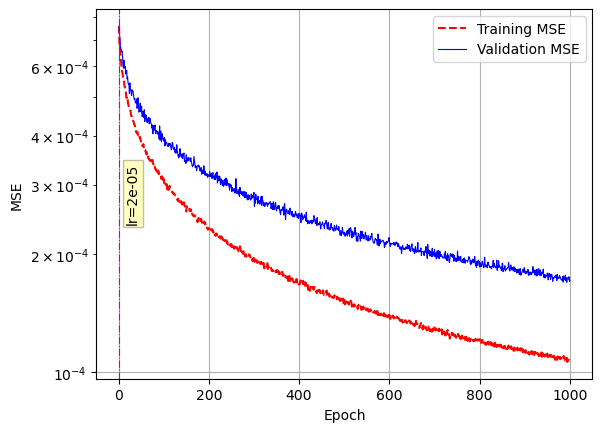

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

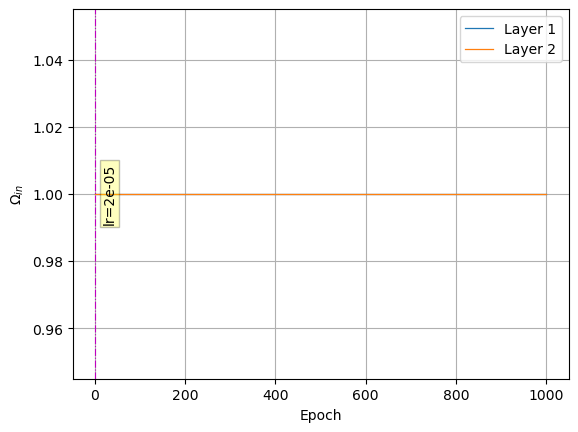



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 1.5


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.7571e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1339e-04 - global_gradnorm: 0.8374 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 0m 54.5s

Epoch 1: val_NMSE improved from inf to 0.00354, saving model to /home/rkaushik/Documents/Thesis/M

Epoch 7/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.3828e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9527e-04 - global_gradnorm: 0.7957 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 4m 12.4s

Epoch 7: val_NMSE improved from 0.00344 to 0.00341, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 467ms/step - loss: 0.0030 - mse: 3.3828e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9484e-04 - global_gradnorm: 0.7935 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.

71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.2309e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8643e-04 - global_gradnorm: 0.7532 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 7m 30.5s

Epoch 13: val_NMSE improved from 0.00336 to 0.00333, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 467ms/step - loss: 0.0029 - mse: 3.2309e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8647e-04 - global_gradnorm: 0.7536 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0028 - mse: 3.1597e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8338e-04 - global_gradnorm: 0.7263 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0033 - val_mse: 3.7855e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_rho_res_1: 0.8000 - val_rho_res_2: 0.8000 - val_alpha_0: 1.0000 - val_alpha_1: 1.0000 - val_alpha_2: 1.0000 - val_omega_in_0: 1.0000 - val_omega_in_1: 1.0000 - val_omega_in_2: 1.0000
Epoch 20/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.1629e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8381e-04 - global_gradnorm: 0.7264 - rho_re

Epoch 26/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.1183e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8053e-04 - global_gradnorm: 0.7462 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 14m 37.1s

Epoch 26: val_NMSE did not improve from 0.00331
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0028 - mse: 3.1183e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8040e-04 - global_gradnorm: 0.7478 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0033 - val_mse: 3.7455e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 33/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0524e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7754e-04 - global_gradnorm: 0.7292 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 18m 26.5s

Epoch 33: val_NMSE did not improve from 0.00328
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0028 - mse: 3.0524e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7727e-04 - global_gradnorm: 0.7288 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0033 - val_mse: 3.7505e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 40/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.9767e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7310e-04 - global_gradnorm: 0.6949 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 22m 16.3s

Epoch 40: val_NMSE did not improve from 0.00315
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0027 - mse: 2.9767e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7297e-04 - global_gradnorm: 0.6938 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0032 - val_mse: 3.6180e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 47/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.9136e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6981e-04 - global_gradnorm: 0.6785 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 26m 5.0s

Epoch 47: val_NMSE did not improve from 0.00315
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0026 - mse: 2.9136e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6955e-04 - global_gradnorm: 0.6799 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0032 - val_mse: 3.6100e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val

Epoch 54/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.9076e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6924e-04 - global_gradnorm: 0.6933 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 29m 53.5s

Epoch 54: val_NMSE improved from 0.00315 to 0.00312, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 466ms/step - loss: 0.0026 - mse: 2.9076e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6944e-04 - global_gradnorm: 0.6933 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 61/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.8450e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6586e-04 - global_gradnorm: 0.6687 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 33m 43.4s

Epoch 61: val_NMSE did not improve from 0.00309
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0026 - mse: 2.8450e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6553e-04 - global_gradnorm: 0.6685 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0032 - val_mse: 3.5956e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 68/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.8110e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6347e-04 - global_gradnorm: 0.6667 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 37m 32.2s

Epoch 68: val_NMSE did not improve from 0.00309
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0026 - mse: 2.8110e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6323e-04 - global_gradnorm: 0.6667 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0031 - val_mse: 3.4966e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 75/1000
71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.8013e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6334e-04 - global_gradnorm: 0.6780 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 41m 20.7s

Epoch 75: val_NMSE did not improve from 0.00309
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0026 - mse: 2.8013e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6302e-04 - global_gradnorm: 0.6771 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0031 - val_mse: 3.5136e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 82/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.7511e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6034e-04 - global_gradnorm: 0.6744 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 45m 9.4s

Epoch 82: val_NMSE did not improve from 0.00309
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0025 - mse: 2.7511e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6066e-04 - global_gradnorm: 0.6755 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0031 - val_mse: 3.5521e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val

Epoch 89/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.7460e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6025e-04 - global_gradnorm: 0.6890 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 48m 58.3s

Epoch 89: val_NMSE improved from 0.00309 to 0.00307, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 467ms/step - loss: 0.0025 - mse: 2.7460e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5971e-04 - global_gradnorm: 0.6874 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1:

Epoch 96/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.6663e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5539e-04 - global_gradnorm: 0.6378 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 52m 48.0s

Epoch 96: val_NMSE did not improve from 0.00306
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0024 - mse: 2.6663e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5544e-04 - global_gradnorm: 0.6392 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0030 - val_mse: 3.4179e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 103/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.6217e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5243e-04 - global_gradnorm: 0.6122 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 56m 36.9s

Epoch 103: val_NMSE did not improve from 0.00306
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0024 - mse: 2.6217e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5246e-04 - global_gradnorm: 0.6140 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0031 - val_mse: 3.4631e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 110/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.6465e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5416e-04 - global_gradnorm: 0.6498 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 0m 26.1s

Epoch 110: val_NMSE did not improve from 0.00306
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0024 - mse: 2.6465e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5443e-04 - global_gradnorm: 0.6489 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0031 - val_mse: 3.4698e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 117/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.6015e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5143e-04 - global_gradnorm: 0.6360 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 4m 15.5s

Epoch 117: val_NMSE improved from 0.00304 to 0.00302, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 468ms/step - loss: 0.0024 - mse: 2.6015e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5130e-04 - global_gradnorm: 0.6359 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1

Epoch 124/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5732e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4977e-04 - global_gradnorm: 0.6190 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 8m 4.9s

Epoch 124: val_NMSE did not improve from 0.00302
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0024 - mse: 2.5732e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4980e-04 - global_gradnorm: 0.6194 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0030 - val_mse: 3.4108e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 131/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5487e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4799e-04 - global_gradnorm: 0.6283 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 11m 53.3s

Epoch 131: val_NMSE did not improve from 0.00302
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0024 - mse: 2.5487e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4813e-04 - global_gradnorm: 0.6295 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0030 - val_mse: 3.3627e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 138/1000
71/71 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5481e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4807e-04 - global_gradnorm: 0.6394 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 15m 41.7s

Epoch 138: val_NMSE did not improve from 0.00302
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0024 - mse: 2.5481e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4873e-04 - global_gradnorm: 0.6408 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0031 - val_mse: 3.4689e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 145/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4957e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4394e-04 - global_gradnorm: 0.6048 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 19m 31.2s

Epoch 145: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0023 - mse: 2.4957e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4397e-04 - global_gradnorm: 0.6045 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0030 - val_mse: 3.3561e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 152/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4820e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4355e-04 - global_gradnorm: 0.6174 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 23m 20.3s

Epoch 152: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 463ms/step - loss: 0.0023 - mse: 2.4820e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4389e-04 - global_gradnorm: 0.6194 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0030 - val_mse: 3.4065e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 159/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4730e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4319e-04 - global_gradnorm: 0.6099 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 27m 9.4s

Epoch 159: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0023 - mse: 2.4730e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4335e-04 - global_gradnorm: 0.6095 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0030 - val_mse: 3.3350e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 166/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4377e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4087e-04 - global_gradnorm: 0.5941 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 30m 58.1s

Epoch 166: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0023 - mse: 2.4377e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4119e-04 - global_gradnorm: 0.5961 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0030 - val_mse: 3.3051e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 173/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4241e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3984e-04 - global_gradnorm: 0.6024 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 34m 47.3s

Epoch 173: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0023 - mse: 2.4241e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3990e-04 - global_gradnorm: 0.6044 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.2879e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 180/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4296e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4014e-04 - global_gradnorm: 0.6117 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 38m 36.0s

Epoch 180: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0023 - mse: 2.4296e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4022e-04 - global_gradnorm: 0.6118 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.2464e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 187/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.4128e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3944e-04 - global_gradnorm: 0.6058 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 42m 25.1s

Epoch 187: val_NMSE improved from 0.00290 to 0.00288, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 466ms/step - loss: 0.0022 - mse: 2.4128e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3902e-04 - global_gradnorm: 0.6039 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_

Epoch 194/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3828e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3744e-04 - global_gradnorm: 0.5859 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 46m 14.5s

Epoch 194: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0022 - mse: 2.3828e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3736e-04 - global_gradnorm: 0.5860 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.2044e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 201/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3401e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3418e-04 - global_gradnorm: 0.5709 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 50m 3.4s

Epoch 201: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0022 - mse: 2.3401e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3382e-04 - global_gradnorm: 0.5705 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0030 - val_mse: 3.3604e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 208/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3472e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3477e-04 - global_gradnorm: 0.5800 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 53m 52.4s

Epoch 208: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0022 - mse: 2.3472e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3485e-04 - global_gradnorm: 0.5803 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.2541e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 215/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3074e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3195e-04 - global_gradnorm: 0.5744 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 57m 42.2s

Epoch 215: val_NMSE did not improve from 0.00286
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0022 - mse: 2.3074e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3206e-04 - global_gradnorm: 0.5758 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.2717e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 222/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3109e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3255e-04 - global_gradnorm: 0.5793 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 1m 31.5s

Epoch 222: val_NMSE did not improve from 0.00286
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0022 - mse: 2.3109e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3244e-04 - global_gradnorm: 0.5807 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0030 - val_mse: 3.3225e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 229/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.3010e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3177e-04 - global_gradnorm: 0.5818 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 5m 20.4s

Epoch 229: val_NMSE did not improve from 0.00282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0022 - mse: 2.3010e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3212e-04 - global_gradnorm: 0.5821 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 3.1441e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 236/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.2850e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3076e-04 - global_gradnorm: 0.5753 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 9m 9.2s

Epoch 236: val_NMSE did not improve from 0.00282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 458ms/step - loss: 0.0021 - mse: 2.2850e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3058e-04 - global_gradnorm: 0.5750 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.1770e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - va

Epoch 243/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.2731e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2957e-04 - global_gradnorm: 0.5753 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 12m 58.1s

Epoch 243: val_NMSE did not improve from 0.00282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0021 - mse: 2.2731e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2991e-04 - global_gradnorm: 0.5754 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.1953e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 250/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.2582e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2902e-04 - global_gradnorm: 0.5641 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 16m 46.9s

Epoch 250: val_NMSE did not improve from 0.00282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0021 - mse: 2.2582e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2896e-04 - global_gradnorm: 0.5649 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.2182e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 257/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.2752e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2985e-04 - global_gradnorm: 0.5851 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 20m 35.5s

Epoch 257: val_NMSE did not improve from 0.00282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0021 - mse: 2.2752e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2969e-04 - global_gradnorm: 0.5846 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.2210e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 264/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.2441e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2788e-04 - global_gradnorm: 0.5744 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 24m 24.1s

Epoch 264: val_NMSE did not improve from 0.00282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0021 - mse: 2.2441e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2792e-04 - global_gradnorm: 0.5749 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 3.1735e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 271/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.2404e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2780e-04 - global_gradnorm: 0.5765 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 28m 13.4s

Epoch 271: val_NMSE did not improve from 0.00281
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0021 - mse: 2.2404e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2788e-04 - global_gradnorm: 0.5766 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 3.1534e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 278/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.2020e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2517e-04 - global_gradnorm: 0.5638 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 32m 2.4s

Epoch 278: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0021 - mse: 2.2020e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2523e-04 - global_gradnorm: 0.5638 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.2292e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 285/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1938e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2428e-04 - global_gradnorm: 0.5694 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 35m 51.5s

Epoch 285: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0021 - mse: 2.1938e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2424e-04 - global_gradnorm: 0.5697 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.2085e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 292/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1769e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2304e-04 - global_gradnorm: 0.5559 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 39m 40.4s

Epoch 292: val_NMSE did not improve from 0.00279
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0021 - mse: 2.1769e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2321e-04 - global_gradnorm: 0.5574 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0029 - val_mse: 3.1794e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 299/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.1560e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2184e-04 - global_gradnorm: 0.5460 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 43m 29.6s

Epoch 299: val_NMSE did not improve from 0.00277
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0020 - mse: 2.1560e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2163e-04 - global_gradnorm: 0.5460 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 3.1039e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 306/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.1375e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2040e-04 - global_gradnorm: 0.5289 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 47m 18.9s

Epoch 306: val_NMSE did not improve from 0.00275
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0020 - mse: 2.1375e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2072e-04 - global_gradnorm: 0.5289 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 3.1073e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 313/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.1328e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2021e-04 - global_gradnorm: 0.5352 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 51m 8.1s

Epoch 313: val_NMSE did not improve from 0.00271
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0020 - mse: 2.1328e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2039e-04 - global_gradnorm: 0.5349 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 3.1510e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 320/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.1348e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2010e-04 - global_gradnorm: 0.5358 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 54m 57.5s

Epoch 320: val_NMSE did not improve from 0.00270
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0020 - mse: 2.1348e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1990e-04 - global_gradnorm: 0.5356 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 3.1001e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 327/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.1099e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1818e-04 - global_gradnorm: 0.5277 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 58m 46.3s

Epoch 327: val_NMSE did not improve from 0.00270
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0020 - mse: 2.1099e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1844e-04 - global_gradnorm: 0.5277 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 3.0363e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 334/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.1173e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1917e-04 - global_gradnorm: 0.5384 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 2m 34.7s

Epoch 334: val_NMSE did not improve from 0.00270
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0020 - mse: 2.1173e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1929e-04 - global_gradnorm: 0.5390 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 3.0648e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 341/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0982e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1741e-04 - global_gradnorm: 0.5450 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 6m 23.4s

Epoch 341: val_NMSE did not improve from 0.00270
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0020 - mse: 2.0982e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1762e-04 - global_gradnorm: 0.5454 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 3.0935e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 348/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.1051e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1810e-04 - global_gradnorm: 0.5477 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 10m 12.2s

Epoch 348: val_NMSE did not improve from 0.00270
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0020 - mse: 2.1051e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1781e-04 - global_gradnorm: 0.5460 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 3.0332e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 355/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0644e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1518e-04 - global_gradnorm: 0.5238 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 14m 1.4s

Epoch 355: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0020 - mse: 2.0644e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1507e-04 - global_gradnorm: 0.5240 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 3.0630e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 362/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0733e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1580e-04 - global_gradnorm: 0.5369 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 17m 49.8s

Epoch 362: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0020 - mse: 2.0733e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1596e-04 - global_gradnorm: 0.5382 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 3.0195e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 369/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0465e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1365e-04 - global_gradnorm: 0.5168 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 21m 38.9s

Epoch 369: val_NMSE did not improve from 0.00266
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0020 - mse: 2.0465e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1388e-04 - global_gradnorm: 0.5154 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 3.0546e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 376/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0448e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1334e-04 - global_gradnorm: 0.5137 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 25m 27.8s

Epoch 376: val_NMSE did not improve from 0.00266
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0020 - mse: 2.0448e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1368e-04 - global_gradnorm: 0.5137 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9775e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 383/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0369e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1287e-04 - global_gradnorm: 0.5147 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 29m 16.4s

Epoch 383: val_NMSE did not improve from 0.00266
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0020 - mse: 2.0369e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1285e-04 - global_gradnorm: 0.5145 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9608e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 390/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0488e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1373e-04 - global_gradnorm: 0.5378 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 33m 5.3s

Epoch 390: val_NMSE did not improve from 0.00266
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0020 - mse: 2.0488e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1360e-04 - global_gradnorm: 0.5374 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 3.0219e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 397/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 2.0167e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1160e-04 - global_gradnorm: 0.5222 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 36m 54.8s

Epoch 397: val_NMSE did not improve from 0.00265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0019 - mse: 2.0167e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1134e-04 - global_gradnorm: 0.5210 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0028 - val_mse: 3.1053e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 404/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9984e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1014e-04 - global_gradnorm: 0.4975 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 40m 44.0s

Epoch 404: val_NMSE did not improve from 0.00265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0019 - mse: 1.9984e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1027e-04 - global_gradnorm: 0.4987 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9834e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 411/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 2.0016e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1037e-04 - global_gradnorm: 0.5196 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 44m 32.8s

Epoch 411: val_NMSE improved from 0.00265 to 0.00265, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 467ms/step - loss: 0.0019 - mse: 2.0016e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1050e-04 - global_gradnorm: 0.5195 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_

Epoch 418/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9986e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1024e-04 - global_gradnorm: 0.5227 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 48m 22.2s

Epoch 418: val_NMSE did not improve from 0.00265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0019 - mse: 1.9986e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0985e-04 - global_gradnorm: 0.5230 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9426e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 425/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9851e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0938e-04 - global_gradnorm: 0.5099 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 52m 11.0s

Epoch 425: val_NMSE did not improve from 0.00265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0019 - mse: 1.9851e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1009e-04 - global_gradnorm: 0.5111 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9783e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 432/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9924e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0976e-04 - global_gradnorm: 0.5277 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 56m 0.4s

Epoch 432: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0019 - mse: 1.9924e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0979e-04 - global_gradnorm: 0.5270 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9782e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 439/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9814e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0913e-04 - global_gradnorm: 0.5163 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 59m 49.3s

Epoch 439: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0019 - mse: 1.9814e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0945e-04 - global_gradnorm: 0.5161 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9898e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 446/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9441e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0605e-04 - global_gradnorm: 0.4917 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 3m 38.1s

Epoch 446: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0019 - mse: 1.9441e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0628e-04 - global_gradnorm: 0.4913 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9257e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 453/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9491e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0632e-04 - global_gradnorm: 0.4998 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 7m 27.1s

Epoch 453: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0019 - mse: 1.9491e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0614e-04 - global_gradnorm: 0.4995 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 3.0230e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 460/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9320e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0540e-04 - global_gradnorm: 0.4918 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 11m 15.5s

Epoch 460: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0019 - mse: 1.9320e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0552e-04 - global_gradnorm: 0.4917 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9388e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 467/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9155e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0384e-04 - global_gradnorm: 0.4876 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 15m 4.5s

Epoch 467: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0019 - mse: 1.9155e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0369e-04 - global_gradnorm: 0.4870 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9319e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 474/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9264e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0472e-04 - global_gradnorm: 0.5018 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 18m 53.8s

Epoch 474: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 463ms/step - loss: 0.0019 - mse: 1.9264e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0469e-04 - global_gradnorm: 0.5030 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9578e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 481/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9228e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0460e-04 - global_gradnorm: 0.4949 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 22m 43.1s

Epoch 481: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0019 - mse: 1.9228e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0460e-04 - global_gradnorm: 0.4949 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9631e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 488/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9292e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0540e-04 - global_gradnorm: 0.5098 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 26m 32.5s

Epoch 488: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0019 - mse: 1.9292e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0560e-04 - global_gradnorm: 0.5088 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0027 - val_mse: 2.9664e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 495/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9140e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0397e-04 - global_gradnorm: 0.5001 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 30m 22.4s

Epoch 495: val_NMSE did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0019 - mse: 1.9140e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0429e-04 - global_gradnorm: 0.4994 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8681e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 502/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8990e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0248e-04 - global_gradnorm: 0.4920 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 34m 11.7s

Epoch 502: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.8990e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0298e-04 - global_gradnorm: 0.4921 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.9006e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 509/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8950e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0200e-04 - global_gradnorm: 0.4987 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 38m 0.5s

Epoch 509: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.8950e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0186e-04 - global_gradnorm: 0.4980 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8985e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 516/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8673e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9959e-04 - global_gradnorm: 0.4821 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 41m 48.8s

Epoch 516: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0018 - mse: 1.8673e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9917e-04 - global_gradnorm: 0.4811 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.9123e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 523/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8803e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0086e-04 - global_gradnorm: 0.4973 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 45m 38.0s

Epoch 523: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.8803e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0080e-04 - global_gradnorm: 0.4970 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8531e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 530/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8777e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0122e-04 - global_gradnorm: 0.4888 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 49m 26.5s

Epoch 530: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0018 - mse: 1.8777e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0143e-04 - global_gradnorm: 0.4893 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.9167e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 537/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8579e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9944e-04 - global_gradnorm: 0.4813 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 53m 16.0s

Epoch 537: val_NMSE did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0018 - mse: 1.8579e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9930e-04 - global_gradnorm: 0.4818 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8942e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 544/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8362e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9802e-04 - global_gradnorm: 0.4654 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 57m 4.2s

Epoch 544: val_NMSE did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.8362e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9800e-04 - global_gradnorm: 0.4650 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8843e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 551/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8547e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9914e-04 - global_gradnorm: 0.4889 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 0m 53.1s

Epoch 551: val_NMSE did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.8547e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9911e-04 - global_gradnorm: 0.4890 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8773e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 558/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8474e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9834e-04 - global_gradnorm: 0.4873 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 4m 41.9s

Epoch 558: val_NMSE did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.8474e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9867e-04 - global_gradnorm: 0.4873 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8301e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 565/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8534e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9878e-04 - global_gradnorm: 0.4985 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 8m 31.3s

Epoch 565: val_NMSE did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0018 - mse: 1.8534e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9869e-04 - global_gradnorm: 0.4978 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8197e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 572/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8209e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9666e-04 - global_gradnorm: 0.4818 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 12m 20.3s

Epoch 572: val_NMSE did not improve from 0.00249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.8209e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9657e-04 - global_gradnorm: 0.4817 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8815e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 579/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8162e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9600e-04 - global_gradnorm: 0.4751 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 16m 8.8s

Epoch 579: val_NMSE did not improve from 0.00249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.8162e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9586e-04 - global_gradnorm: 0.4736 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8044e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 586/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8110e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9559e-04 - global_gradnorm: 0.4814 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 19m 57.6s

Epoch 586: val_NMSE did not improve from 0.00249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.8110e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9588e-04 - global_gradnorm: 0.4821 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7763e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 593/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8118e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9573e-04 - global_gradnorm: 0.4772 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 23m 46.2s

Epoch 593: val_NMSE did not improve from 0.00249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.8118e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9559e-04 - global_gradnorm: 0.4775 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8154e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 600/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7998e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9503e-04 - global_gradnorm: 0.4769 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 27m 35.3s

Epoch 600: val_NMSE did not improve from 0.00249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.7998e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9491e-04 - global_gradnorm: 0.4767 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.7983e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 607/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8078e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9539e-04 - global_gradnorm: 0.4918 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 31m 24.0s

Epoch 607: val_NMSE did not improve from 0.00249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.8078e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9504e-04 - global_gradnorm: 0.4911 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8715e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 614/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7954e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9462e-04 - global_gradnorm: 0.4701 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 35m 13.5s

Epoch 614: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0018 - mse: 1.7954e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9471e-04 - global_gradnorm: 0.4696 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8531e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 621/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7940e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9434e-04 - global_gradnorm: 0.4788 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 39m 2.6s

Epoch 621: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0018 - mse: 1.7940e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9450e-04 - global_gradnorm: 0.4793 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8895e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 628/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8015e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9514e-04 - global_gradnorm: 0.4863 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 42m 51.2s

Epoch 628: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0018 - mse: 1.8015e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9556e-04 - global_gradnorm: 0.4878 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8052e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 635/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7795e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9330e-04 - global_gradnorm: 0.4697 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 46m 40.2s

Epoch 635: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0018 - mse: 1.7795e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9364e-04 - global_gradnorm: 0.4702 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7891e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 642/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7624e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9174e-04 - global_gradnorm: 0.4585 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 50m 29.2s

Epoch 642: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0017 - mse: 1.7624e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9155e-04 - global_gradnorm: 0.4585 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.7967e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 649/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7683e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9219e-04 - global_gradnorm: 0.4640 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 54m 18.0s

Epoch 649: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0017 - mse: 1.7683e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9216e-04 - global_gradnorm: 0.4631 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7850e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 656/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7460e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9029e-04 - global_gradnorm: 0.4551 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 58m 7.1s

Epoch 656: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0017 - mse: 1.7460e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9044e-04 - global_gradnorm: 0.4546 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7561e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 663/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7679e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9231e-04 - global_gradnorm: 0.4822 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 1m 56.3s

Epoch 663: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0017 - mse: 1.7679e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9226e-04 - global_gradnorm: 0.4825 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8189e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 670/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7371e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8960e-04 - global_gradnorm: 0.4483 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 5m 45.9s

Epoch 670: val_NMSE did not improve from 0.00242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0017 - mse: 1.7371e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8978e-04 - global_gradnorm: 0.4484 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7469e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 677/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7390e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8980e-04 - global_gradnorm: 0.4558 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 9m 34.6s

Epoch 677: val_NMSE did not improve from 0.00242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0017 - mse: 1.7390e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8986e-04 - global_gradnorm: 0.4559 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.7970e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 684/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7525e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9121e-04 - global_gradnorm: 0.4663 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 13m 23.5s

Epoch 684: val_NMSE improved from 0.00242 to 0.00241, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 466ms/step - loss: 0.0017 - mse: 1.7525e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9111e-04 - global_gradnorm: 0.4656 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_

Epoch 691/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7333e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8937e-04 - global_gradnorm: 0.4533 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 17m 13.0s

Epoch 691: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 463ms/step - loss: 0.0017 - mse: 1.7333e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8931e-04 - global_gradnorm: 0.4531 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7270e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 698/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7129e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8782e-04 - global_gradnorm: 0.4348 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 21m 1.9s

Epoch 698: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0017 - mse: 1.7129e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8814e-04 - global_gradnorm: 0.4352 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7527e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 705/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7363e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8980e-04 - global_gradnorm: 0.4753 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 24m 50.5s

Epoch 705: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0017 - mse: 1.7363e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8964e-04 - global_gradnorm: 0.4740 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7749e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 712/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7069e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8743e-04 - global_gradnorm: 0.4408 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 28m 39.1s

Epoch 712: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0017 - mse: 1.7069e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8732e-04 - global_gradnorm: 0.4404 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7326e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 719/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7107e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8732e-04 - global_gradnorm: 0.4591 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 32m 28.2s

Epoch 719: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0017 - mse: 1.7107e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8729e-04 - global_gradnorm: 0.4602 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7493e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 726/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7108e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8759e-04 - global_gradnorm: 0.4604 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 36m 17.4s

Epoch 726: val_NMSE did not improve from 0.00238
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0017 - mse: 1.7108e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8775e-04 - global_gradnorm: 0.4607 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7581e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 733/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6868e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8573e-04 - global_gradnorm: 0.4427 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 40m 7.1s

Epoch 733: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 463ms/step - loss: 0.0017 - mse: 1.6868e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8561e-04 - global_gradnorm: 0.4422 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7882e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 740/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6900e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8583e-04 - global_gradnorm: 0.4511 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 43m 55.6s

Epoch 740: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0017 - mse: 1.6900e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8578e-04 - global_gradnorm: 0.4499 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7147e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 747/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6842e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8554e-04 - global_gradnorm: 0.4479 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 47m 44.3s

Epoch 747: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0017 - mse: 1.6842e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8547e-04 - global_gradnorm: 0.4479 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7186e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 754/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6958e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8597e-04 - global_gradnorm: 0.4678 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 51m 32.9s

Epoch 754: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0017 - mse: 1.6958e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8633e-04 - global_gradnorm: 0.4698 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0026 - val_mse: 2.8128e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 761/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6840e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8548e-04 - global_gradnorm: 0.4539 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 55m 22.0s

Epoch 761: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0017 - mse: 1.6840e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8538e-04 - global_gradnorm: 0.4534 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.6774e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 768/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6692e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8400e-04 - global_gradnorm: 0.4326 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 59m 11.0s

Epoch 768: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0017 - mse: 1.6692e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8399e-04 - global_gradnorm: 0.4335 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7001e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 775/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6820e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8494e-04 - global_gradnorm: 0.4538 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 2m 59.7s

Epoch 775: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0017 - mse: 1.6820e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8477e-04 - global_gradnorm: 0.4534 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7069e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 782/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6768e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8487e-04 - global_gradnorm: 0.4599 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 6m 48.6s

Epoch 782: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0017 - mse: 1.6768e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8470e-04 - global_gradnorm: 0.4589 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7372e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 789/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6669e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8364e-04 - global_gradnorm: 0.4458 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 10m 37.4s

Epoch 789: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0017 - mse: 1.6669e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8366e-04 - global_gradnorm: 0.4455 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.6781e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 796/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6522e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8266e-04 - global_gradnorm: 0.4447 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 14m 26.7s

Epoch 796: val_NMSE did not improve from 0.00236
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0017 - mse: 1.6522e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8299e-04 - global_gradnorm: 0.4449 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.6987e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 803/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6502e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8271e-04 - global_gradnorm: 0.4390 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 18m 15.4s

Epoch 803: val_NMSE did not improve from 0.00236
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0016 - mse: 1.6502e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8291e-04 - global_gradnorm: 0.4408 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6388e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 810/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6476e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8212e-04 - global_gradnorm: 0.4402 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 22m 4.8s

Epoch 810: val_NMSE did not improve from 0.00235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 463ms/step - loss: 0.0016 - mse: 1.6476e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8219e-04 - global_gradnorm: 0.4394 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.6741e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 817/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6705e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8422e-04 - global_gradnorm: 0.4619 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 25m 53.6s

Epoch 817: val_NMSE did not improve from 0.00235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0017 - mse: 1.6705e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8428e-04 - global_gradnorm: 0.4624 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.7108e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 824/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6391e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8167e-04 - global_gradnorm: 0.4377 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 29m 42.7s

Epoch 824: val_NMSE did not improve from 0.00235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 463ms/step - loss: 0.0016 - mse: 1.6391e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8162e-04 - global_gradnorm: 0.4366 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.6835e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 831/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.6553e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8305e-04 - global_gradnorm: 0.4538 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 33m 31.0s

Epoch 831: val_NMSE did not improve from 0.00235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0017 - mse: 1.6553e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8301e-04 - global_gradnorm: 0.4531 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6129e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 838/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6357e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8115e-04 - global_gradnorm: 0.4357 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 37m 19.6s

Epoch 838: val_NMSE did not improve from 0.00235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0016 - mse: 1.6357e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8124e-04 - global_gradnorm: 0.4352 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.6876e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 845/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6218e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8038e-04 - global_gradnorm: 0.4229 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 41m 8.2s

Epoch 845: val_NMSE did not improve from 0.00235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0016 - mse: 1.6218e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8030e-04 - global_gradnorm: 0.4233 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.6976e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 852/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6088e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7902e-04 - global_gradnorm: 0.4182 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 44m 57.8s

Epoch 852: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0016 - mse: 1.6088e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7912e-04 - global_gradnorm: 0.4174 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6351e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 859/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6125e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.7931e-04 - global_gradnorm: 0.4274 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 48m 46.3s

Epoch 859: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0016 - mse: 1.6125e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.7910e-04 - global_gradnorm: 0.4266 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0025 - val_mse: 2.6971e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 866/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6247e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8040e-04 - global_gradnorm: 0.4417 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 52m 35.3s

Epoch 866: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0016 - mse: 1.6247e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8062e-04 - global_gradnorm: 0.4426 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6519e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 873/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6000e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7824e-04 - global_gradnorm: 0.4162 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 7h 56m 24.4s

Epoch 873: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0016 - mse: 1.6000e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7829e-04 - global_gradnorm: 0.4174 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6360e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 880/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5989e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7821e-04 - global_gradnorm: 0.4262 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 0m 12.1s

Epoch 880: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0016 - mse: 1.5989e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7818e-04 - global_gradnorm: 0.4254 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6543e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 887/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6045e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7844e-04 - global_gradnorm: 0.4273 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 3m 59.9s

Epoch 887: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0016 - mse: 1.6045e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7878e-04 - global_gradnorm: 0.4285 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.5975e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 894/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6092e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7888e-04 - global_gradnorm: 0.4396 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 7m 47.8s

Epoch 894: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0016 - mse: 1.6092e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7879e-04 - global_gradnorm: 0.4389 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6417e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 901/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6012e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7804e-04 - global_gradnorm: 0.4353 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 11m 36.6s

Epoch 901: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0016 - mse: 1.6012e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7790e-04 - global_gradnorm: 0.4354 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.5971e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 908/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5922e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7783e-04 - global_gradnorm: 0.4309 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 15m 25.3s

Epoch 908: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0016 - mse: 1.5922e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7775e-04 - global_gradnorm: 0.4298 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6137e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 915/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5930e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7780e-04 - global_gradnorm: 0.4237 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 19m 14.9s

Epoch 915: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0016 - mse: 1.5930e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7804e-04 - global_gradnorm: 0.4240 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6558e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 922/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5711e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7573e-04 - global_gradnorm: 0.4146 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 23m 4.6s

Epoch 922: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0016 - mse: 1.5711e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7577e-04 - global_gradnorm: 0.4154 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6266e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 929/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5938e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7761e-04 - global_gradnorm: 0.4354 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 26m 53.3s

Epoch 929: val_NMSE improved from 0.00231 to 0.00231, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 467ms/step - loss: 0.0016 - mse: 1.5938e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7774e-04 - global_gradnorm: 0.4353 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_

Epoch 936/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5845e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7681e-04 - global_gradnorm: 0.4344 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 30m 42.7s

Epoch 936: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0016 - mse: 1.5845e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7677e-04 - global_gradnorm: 0.4359 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.5976e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 943/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5705e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7598e-04 - global_gradnorm: 0.4140 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 34m 31.6s

Epoch 943: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 462ms/step - loss: 0.0016 - mse: 1.5705e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7594e-04 - global_gradnorm: 0.4133 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.5663e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 950/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5724e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7575e-04 - global_gradnorm: 0.4233 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 38m 20.8s

Epoch 950: val_NMSE did not improve from 0.00230
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0016 - mse: 1.5724e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7570e-04 - global_gradnorm: 0.4248 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6007e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 957/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5713e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7584e-04 - global_gradnorm: 0.4292 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 42m 9.9s

Epoch 957: val_NMSE did not improve from 0.00230
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0016 - mse: 1.5713e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7568e-04 - global_gradnorm: 0.4292 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6140e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 964/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5487e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7387e-04 - global_gradnorm: 0.4126 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 45m 58.5s

Epoch 964: val_NMSE improved from 0.00230 to 0.00229, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 466ms/step - loss: 0.0016 - mse: 1.5487e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7410e-04 - global_gradnorm: 0.4138 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_

Epoch 971/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5501e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7403e-04 - global_gradnorm: 0.4154 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 49m 48.2s

Epoch 971: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 461ms/step - loss: 0.0016 - mse: 1.5501e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7416e-04 - global_gradnorm: 0.4155 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.5774e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 978/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5590e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7480e-04 - global_gradnorm: 0.4280 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 53m 36.6s

Epoch 978: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 459ms/step - loss: 0.0016 - mse: 1.5590e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7495e-04 - global_gradnorm: 0.4281 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.6183e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 985/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5580e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7463e-04 - global_gradnorm: 0.4229 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 8h 57m 25.3s

Epoch 985: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0016 - mse: 1.5580e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7445e-04 - global_gradnorm: 0.4227 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.5545e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - 

Epoch 992/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5473e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7347e-04 - global_gradnorm: 0.4216 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 9h 1m 14.3s

Epoch 992: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 460ms/step - loss: 0.0016 - mse: 1.5473e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7347e-04 - global_gradnorm: 0.4206 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0023 - val_mse: 2.5346e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - v

Epoch 999/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.5412e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7298e-04 - global_gradnorm: 0.4155 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 9h 5m 3.0s

Epoch 999: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 33s 458ms/step - loss: 0.0016 - mse: 1.5412e-04 - NMSE: 0.0014 - covmat_fro_loss: 2.7307e-04 - global_gradnorm: 0.4154 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0024 - val_mse: 2.5470e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - va

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

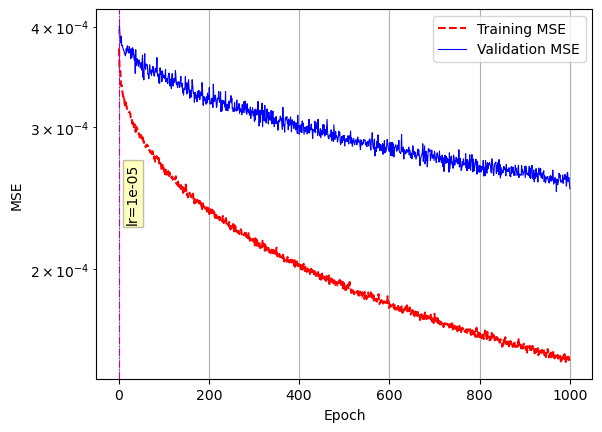

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

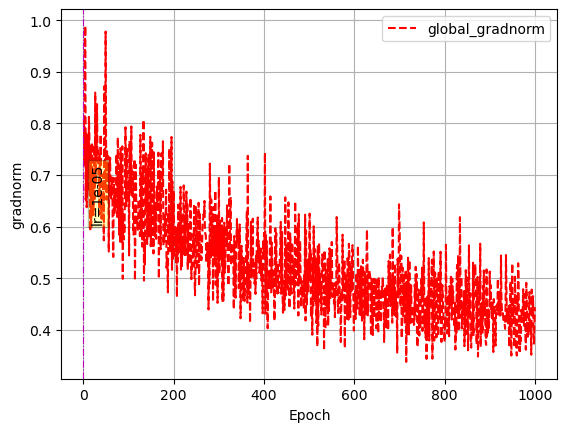

<Figure size 640x480 with 0 Axes>

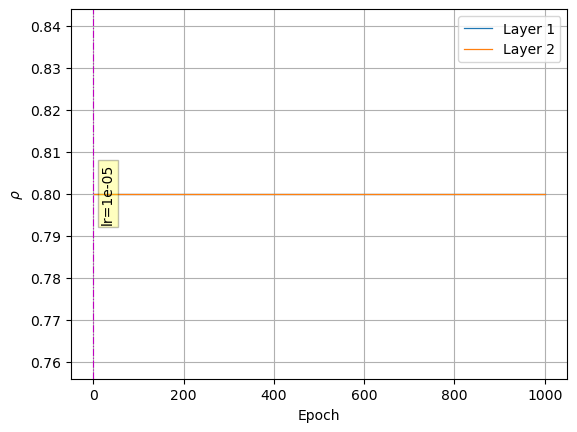

<Figure size 640x480 with 0 Axes>

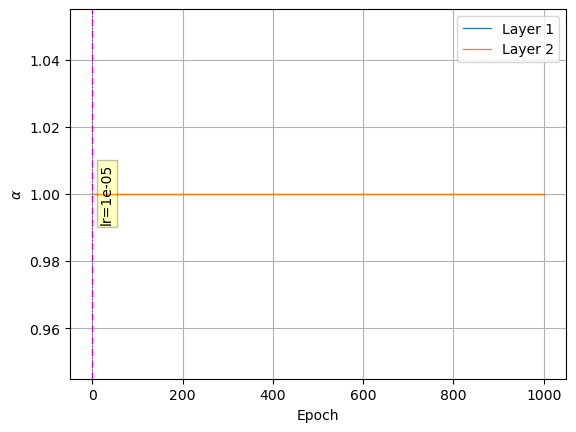

<Figure size 640x480 with 0 Axes>

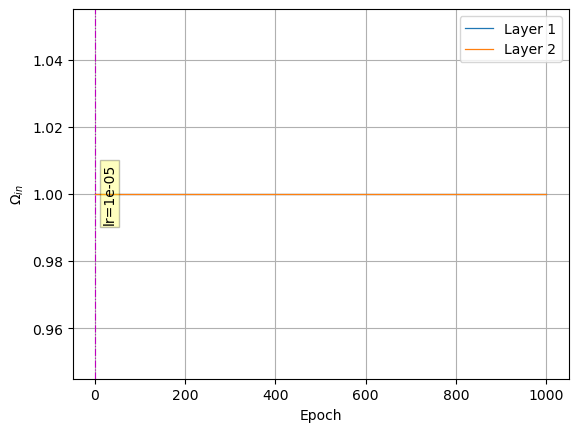



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 1.0


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
58/58 [==============================] - ETA: 0s - loss: 0.0083 - mse: 0.0014 - NMSE: 0.0122 - covmat_fro_loss: 0.0014 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 1m 41.3s

Epoch 1: val_NMSE improved from inf to 0.01317, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/

Epoch 7/1000
58/58 [==============================] - ETA: 0s - loss: 0.0074 - mse: 0.0012 - NMSE: 0.0108 - covmat_fro_loss: 0.0013 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 5m 13.4s

Epoch 7: val_NMSE improved from 0.01272 to 0.01261, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 36s 616ms/step - loss: 0.0074 - mse: 0.0012 - NMSE: 0.0108 - covmat_fro_loss: 0.0013 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_

Epoch 14/1000
58/58 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0012 - NMSE: 0.0104 - covmat_fro_loss: 0.0013 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 9m 20.6s

Epoch 14: val_NMSE did not improve from 0.01249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 608ms/step - loss: 0.0071 - mse: 0.0012 - NMSE: 0.0104 - covmat_fro_loss: 0.0013 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0085 - val_mse: 0.0014 - val_NMSE: 0.0126 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.

Epoch 21/1000
58/58 [==============================] - ETA: 0s - loss: 0.0069 - mse: 0.0011 - NMSE: 0.0100 - covmat_fro_loss: 0.0013 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 13m 27.8s

Epoch 21: val_NMSE did not improve from 0.01237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 607ms/step - loss: 0.0069 - mse: 0.0011 - NMSE: 0.0100 - covmat_fro_loss: 0.0013 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0088 - val_mse: 0.0014 - val_NMSE: 0.0130 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 28/1000
58/58 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0013 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 17m 34.1s

Epoch 28: val_NMSE did not improve from 0.01223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 602ms/step - loss: 0.0068 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0013 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0124 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 35/1000
58/58 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0013 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 21m 40.2s

Epoch 35: val_NMSE did not improve from 0.01223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 608ms/step - loss: 0.0067 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0013 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0085 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 42/1000
58/58 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0096 - covmat_fro_loss: 0.0013 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 25m 47.0s

Epoch 42: val_NMSE did not improve from 0.01217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 611ms/step - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0096 - covmat_fro_loss: 0.0013 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 49/1000
58/58 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 29m 52.3s

Epoch 49: val_NMSE did not improve from 0.01217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 604ms/step - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0124 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 56/1000
58/58 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 33m 59.3s

Epoch 56: val_NMSE did not improve from 0.01206
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 63/1000
58/58 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 38m 5.2s

Epoch 63: val_NMSE improved from 0.01202 to 0.01196, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 36s 615ms/step - loss: 0.0064 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_i

Epoch 70/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 42m 10.8s

Epoch 70: val_NMSE did not improve from 0.01196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0063 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0082 - val_mse: 0.0013 - val_NMSE: 0.0121 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 77/1000
58/58 [==============================] - ETA: 0s - loss: 0.0063 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 46m 17.2s

Epoch 77: val_NMSE did not improve from 0.01196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0063 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0085 - val_mse: 0.0014 - val_NMSE: 0.0124 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 84/1000
58/58 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.9870e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 50m 23.0s

Epoch 84: val_NMSE did not improve from 0.01196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 609ms/step - loss: 0.0062 - mse: 9.9870e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0082 - val_mse: 0.0013 - val_NMSE: 0.0121 - val_covmat_fro_loss: 0.0000e+00 - val_global_gra

Epoch 91/1000
58/58 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.9676e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 54m 29.9s

Epoch 91: val_NMSE did not improve from 0.01190
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 607ms/step - loss: 0.0062 - mse: 9.9676e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0082 - val_mse: 0.0013 - val_NMSE: 0.0120 - val_covmat_fro_loss: 0.0000e+00 - val_global_gra

Epoch 98/1000
58/58 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.8448e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 58m 35.9s

Epoch 98: val_NMSE did not improve from 0.01189
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0062 - mse: 9.8448e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0084 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gra

Epoch 105/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.7394e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 2m 42.7s

Epoch 105: val_NMSE did not improve from 0.01188
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 608ms/step - loss: 0.0061 - mse: 9.7394e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0082 - val_mse: 0.0013 - val_NMSE: 0.0121 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 112/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.7419e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 6m 48.8s

Epoch 112: val_NMSE did not improve from 0.01188
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 609ms/step - loss: 0.0061 - mse: 9.7419e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0119 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 119/1000
58/58 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.6653e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 10m 55.0s

Epoch 119: val_NMSE did not improve from 0.01188
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 608ms/step - loss: 0.0061 - mse: 9.6653e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0082 - val_mse: 0.0013 - val_NMSE: 0.0120 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 126/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.6493e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 15m 0.8s

Epoch 126: val_NMSE did not improve from 0.01188
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0060 - mse: 9.6493e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0119 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 133/1000
58/58 [==============================] - ETA: 0s - loss: 0.0060 - mse: 9.5436e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 19m 6.7s

Epoch 133: val_NMSE did not improve from 0.01185
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0060 - mse: 9.5436e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0119 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 140/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.4302e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 23m 12.0s

Epoch 140: val_NMSE did not improve from 0.01185
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 603ms/step - loss: 0.0059 - mse: 9.4302e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0083 - val_mse: 0.0013 - val_NMSE: 0.0121 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 147/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.3943e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 27m 18.6s

Epoch 147: val_NMSE did not improve from 0.01167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0059 - mse: 9.3943e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0119 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 154/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.3929e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 31m 25.1s

Epoch 154: val_NMSE did not improve from 0.01157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 608ms/step - loss: 0.0059 - mse: 9.3929e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0119 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 161/1000
58/58 [==============================] - ETA: 0s - loss: 0.0058 - mse: 9.2717e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 35m 31.3s

Epoch 161: val_NMSE did not improve from 0.01157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0058 - mse: 9.2717e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0080 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 168/1000
58/58 [==============================] - ETA: 0s - loss: 0.0058 - mse: 9.2632e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 39m 37.0s

Epoch 168: val_NMSE did not improve from 0.01157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0058 - mse: 9.2632e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0080 - val_mse: 0.0013 - val_NMSE: 0.0117 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 175/1000
58/58 [==============================] - ETA: 0s - loss: 0.0058 - mse: 9.2378e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 43m 43.2s

Epoch 175: val_NMSE did not improve from 0.01157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 603ms/step - loss: 0.0058 - mse: 9.2378e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 182/1000
58/58 [==============================] - ETA: 0s - loss: 0.0058 - mse: 9.1445e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 47m 49.4s

Epoch 182: val_NMSE did not improve from 0.01157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 612ms/step - loss: 0.0058 - mse: 9.1445e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 189/1000
58/58 [==============================] - ETA: 0s - loss: 0.0057 - mse: 9.1021e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 51m 55.4s

Epoch 189: val_NMSE did not improve from 0.01157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0057 - mse: 9.1021e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 196/1000
58/58 [==============================] - ETA: 0s - loss: 0.0057 - mse: 9.0750e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 56m 1.9s

Epoch 196: val_NMSE did not improve from 0.01152
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 607ms/step - loss: 0.0057 - mse: 9.0750e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 203/1000
58/58 [==============================] - ETA: 0s - loss: 0.0057 - mse: 9.0823e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 0m 7.6s

Epoch 203: val_NMSE did not improve from 0.01152
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0057 - mse: 9.0823e-04 - NMSE: 0.0082 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_covmat_fro_loss: 0.0000e+00 - val_global_gra

Epoch 210/1000
58/58 [==============================] - ETA: 0s - loss: 0.0057 - mse: 8.9859e-04 - NMSE: 0.0081 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 4m 13.4s

Epoch 210: val_NMSE did not improve from 0.01152
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0057 - mse: 8.9859e-04 - NMSE: 0.0081 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0119 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 217/1000
58/58 [==============================] - ETA: 0s - loss: 0.0057 - mse: 9.0071e-04 - NMSE: 0.0081 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 8m 19.4s

Epoch 217: val_NMSE did not improve from 0.01152
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 604ms/step - loss: 0.0057 - mse: 9.0071e-04 - NMSE: 0.0081 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0081 - val_mse: 0.0013 - val_NMSE: 0.0119 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 224/1000
58/58 [==============================] - ETA: 0s - loss: 0.0056 - mse: 8.8945e-04 - NMSE: 0.0080 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 12m 25.6s

Epoch 224: val_NMSE did not improve from 0.01149
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 607ms/step - loss: 0.0056 - mse: 8.8945e-04 - NMSE: 0.0080 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0080 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 231/1000
58/58 [==============================] - ETA: 0s - loss: 0.0056 - mse: 8.8784e-04 - NMSE: 0.0080 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 16m 31.3s

Epoch 231: val_NMSE did not improve from 0.01149
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0056 - mse: 8.8784e-04 - NMSE: 0.0080 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0079 - val_mse: 0.0013 - val_NMSE: 0.0116 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 238/1000
58/58 [==============================] - ETA: 0s - loss: 0.0056 - mse: 8.8156e-04 - NMSE: 0.0079 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 20m 36.9s

Epoch 238: val_NMSE did not improve from 0.01149
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 608ms/step - loss: 0.0056 - mse: 8.8156e-04 - NMSE: 0.0079 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0080 - val_mse: 0.0013 - val_NMSE: 0.0117 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 245/1000
58/58 [==============================] - ETA: 0s - loss: 0.0056 - mse: 8.7824e-04 - NMSE: 0.0079 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 24m 43.0s

Epoch 245: val_NMSE did not improve from 0.01149
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0056 - mse: 8.7824e-04 - NMSE: 0.0079 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0079 - val_mse: 0.0013 - val_NMSE: 0.0115 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 252/1000
58/58 [==============================] - ETA: 0s - loss: 0.0055 - mse: 8.7346e-04 - NMSE: 0.0079 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 28m 49.5s

Epoch 252: val_NMSE improved from 0.01149 to 0.01141, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 36s 617ms/step - loss: 0.0055 - mse: 8.7346e-04 - NMSE: 0.0079 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.000

Epoch 259/1000
58/58 [==============================] - ETA: 0s - loss: 0.0055 - mse: 8.7697e-04 - NMSE: 0.0079 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 32m 54.5s

Epoch 259: val_NMSE did not improve from 0.01141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 601ms/step - loss: 0.0055 - mse: 8.7697e-04 - NMSE: 0.0079 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0080 - val_mse: 0.0013 - val_NMSE: 0.0116 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 266/1000
58/58 [==============================] - ETA: 0s - loss: 0.0055 - mse: 8.6414e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 36m 58.7s

Epoch 266: val_NMSE did not improve from 0.01141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 603ms/step - loss: 0.0055 - mse: 8.6414e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0079 - val_mse: 0.0013 - val_NMSE: 0.0115 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 273/1000
58/58 [==============================] - ETA: 0s - loss: 0.0055 - mse: 8.6897e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 41m 3.4s

Epoch 273: val_NMSE did not improve from 0.01141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0055 - mse: 8.6897e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0082 - val_mse: 0.0013 - val_NMSE: 0.0120 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 280/1000
58/58 [==============================] - ETA: 0s - loss: 0.0055 - mse: 8.6400e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 45m 7.9s

Epoch 280: val_NMSE did not improve from 0.01141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 603ms/step - loss: 0.0055 - mse: 8.6400e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0080 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 287/1000
58/58 [==============================] - ETA: 0s - loss: 0.0054 - mse: 8.5899e-04 - NMSE: 0.0077 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 49m 12.1s

Epoch 287: val_NMSE did not improve from 0.01141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 604ms/step - loss: 0.0054 - mse: 8.5899e-04 - NMSE: 0.0077 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0079 - val_mse: 0.0013 - val_NMSE: 0.0116 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 294/1000
58/58 [==============================] - ETA: 0s - loss: 0.0054 - mse: 8.5697e-04 - NMSE: 0.0077 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 53m 17.3s

Epoch 294: val_NMSE did not improve from 0.01140
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 604ms/step - loss: 0.0054 - mse: 8.5697e-04 - NMSE: 0.0077 - covmat_fro_loss: 0.0012 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0079 - val_mse: 0.0013 - val_NMSE: 0.0116 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 301/1000
58/58 [==============================] - ETA: 0s - loss: 0.0054 - mse: 8.4924e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 2h 57m 22.7s

Epoch 301: val_NMSE did not improve from 0.01135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 603ms/step - loss: 0.0054 - mse: 8.4924e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0078 - val_mse: 0.0013 - val_NMSE: 0.0115 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 308/1000
58/58 [==============================] - ETA: 0s - loss: 0.0053 - mse: 8.4108e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 1m 27.2s

Epoch 308: val_NMSE did not improve from 0.01135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0053 - mse: 8.4108e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0079 - val_mse: 0.0013 - val_NMSE: 0.0115 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 315/1000
58/58 [==============================] - ETA: 0s - loss: 0.0054 - mse: 8.4363e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 5m 32.1s

Epoch 315: val_NMSE did not improve from 0.01135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 602ms/step - loss: 0.0054 - mse: 8.4363e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0079 - val_mse: 0.0013 - val_NMSE: 0.0116 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 322/1000
58/58 [==============================] - ETA: 0s - loss: 0.0053 - mse: 8.3953e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 9m 36.6s

Epoch 322: val_NMSE did not improve from 0.01131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 34s 593ms/step - loss: 0.0053 - mse: 8.3953e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0080 - val_mse: 0.0013 - val_NMSE: 0.0116 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 329/1000
58/58 [==============================] - ETA: 0s - loss: 0.0053 - mse: 8.3109e-04 - NMSE: 0.0075 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 13m 42.0s

Epoch 329: val_NMSE improved from 0.01131 to 0.01118, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 36s 613ms/step - loss: 0.0053 - mse: 8.3109e-04 - NMSE: 0.0075 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.000

Epoch 336/1000
58/58 [==============================] - ETA: 0s - loss: 0.0053 - mse: 8.3438e-04 - NMSE: 0.0075 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 17m 48.5s

Epoch 336: val_NMSE did not improve from 0.01118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 608ms/step - loss: 0.0053 - mse: 8.3438e-04 - NMSE: 0.0075 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0078 - val_mse: 0.0013 - val_NMSE: 0.0114 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 343/1000
58/58 [==============================] - ETA: 0s - loss: 0.0053 - mse: 8.2942e-04 - NMSE: 0.0075 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 21m 54.0s

Epoch 343: val_NMSE did not improve from 0.01118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 603ms/step - loss: 0.0053 - mse: 8.2942e-04 - NMSE: 0.0075 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0078 - val_mse: 0.0013 - val_NMSE: 0.0114 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 350/1000
58/58 [==============================] - ETA: 0s - loss: 0.0053 - mse: 8.2585e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 25m 59.7s

Epoch 350: val_NMSE did not improve from 0.01118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0053 - mse: 8.2585e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0080 - val_mse: 0.0013 - val_NMSE: 0.0117 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 357/1000
58/58 [==============================] - ETA: 0s - loss: 0.0053 - mse: 8.2695e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 30m 4.9s

Epoch 357: val_NMSE did not improve from 0.01118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 604ms/step - loss: 0.0053 - mse: 8.2695e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0078 - val_mse: 0.0013 - val_NMSE: 0.0113 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 364/1000
58/58 [==============================] - ETA: 0s - loss: 0.0053 - mse: 8.2692e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 34m 10.6s

Epoch 364: val_NMSE did not improve from 0.01118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 607ms/step - loss: 0.0053 - mse: 8.2692e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0078 - val_mse: 0.0013 - val_NMSE: 0.0115 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 371/1000
58/58 [==============================] - ETA: 0s - loss: 0.0052 - mse: 8.2323e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 38m 16.8s

Epoch 371: val_NMSE did not improve from 0.01118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0052 - mse: 8.2323e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0079 - val_mse: 0.0013 - val_NMSE: 0.0116 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 378/1000
58/58 [==============================] - ETA: 0s - loss: 0.0052 - mse: 8.2140e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 42m 22.7s

Epoch 378: val_NMSE did not improve from 0.01118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 608ms/step - loss: 0.0052 - mse: 8.2140e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0078 - val_mse: 0.0013 - val_NMSE: 0.0115 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 385/1000
58/58 [==============================] - ETA: 0s - loss: 0.0052 - mse: 8.1619e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 46m 28.7s

Epoch 385: val_NMSE did not improve from 0.01118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 607ms/step - loss: 0.0052 - mse: 8.1619e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0013 - val_NMSE: 0.0113 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 392/1000
58/58 [==============================] - ETA: 0s - loss: 0.0052 - mse: 8.1602e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 50m 34.8s

Epoch 392: val_NMSE did not improve from 0.01108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 608ms/step - loss: 0.0052 - mse: 8.1602e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0078 - val_mse: 0.0013 - val_NMSE: 0.0113 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 399/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 8.0560e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 54m 40.4s

Epoch 399: val_NMSE did not improve from 0.01108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0051 - mse: 8.0560e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0078 - val_mse: 0.0013 - val_NMSE: 0.0113 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 406/1000
58/58 [==============================] - ETA: 0s - loss: 0.0052 - mse: 8.0754e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 3h 58m 46.1s

Epoch 406: val_NMSE did not improve from 0.01108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0052 - mse: 8.0754e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0079 - val_mse: 0.0013 - val_NMSE: 0.0115 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 413/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 8.0636e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 2m 52.3s

Epoch 413: val_NMSE did not improve from 0.01108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0051 - mse: 8.0636e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0112 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 420/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 7.9957e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 6m 58.2s

Epoch 420: val_NMSE did not improve from 0.01108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 604ms/step - loss: 0.0051 - mse: 7.9957e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0076 - val_mse: 0.0012 - val_NMSE: 0.0111 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 427/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 8.0499e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 11m 4.8s

Epoch 427: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0051 - mse: 8.0499e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0112 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 434/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 7.9798e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 15m 10.8s

Epoch 434: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0051 - mse: 7.9798e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0078 - val_mse: 0.0013 - val_NMSE: 0.0114 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 441/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 7.9109e-04 - NMSE: 0.0071 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 19m 16.6s

Epoch 441: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 603ms/step - loss: 0.0051 - mse: 7.9109e-04 - NMSE: 0.0071 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0013 - val_NMSE: 0.0113 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 448/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 8.0105e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 23m 22.8s

Epoch 448: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 607ms/step - loss: 0.0051 - mse: 8.0105e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0112 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 455/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 7.9468e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 27m 28.5s

Epoch 455: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0051 - mse: 7.9468e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0112 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 462/1000
58/58 [==============================] - ETA: 0s - loss: 0.0050 - mse: 7.8623e-04 - NMSE: 0.0071 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 31m 34.2s

Epoch 462: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 603ms/step - loss: 0.0050 - mse: 7.8623e-04 - NMSE: 0.0071 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0013 - val_NMSE: 0.0113 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 469/1000
58/58 [==============================] - ETA: 0s - loss: 0.0050 - mse: 7.8743e-04 - NMSE: 0.0071 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 35m 40.4s

Epoch 469: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 609ms/step - loss: 0.0050 - mse: 7.8743e-04 - NMSE: 0.0071 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0013 - val_NMSE: 0.0113 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 476/1000
58/58 [==============================] - ETA: 0s - loss: 0.0050 - mse: 7.8275e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 39m 46.3s

Epoch 476: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 602ms/step - loss: 0.0050 - mse: 7.8275e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0079 - val_mse: 0.0013 - val_NMSE: 0.0115 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 483/1000
58/58 [==============================] - ETA: 0s - loss: 0.0050 - mse: 7.8117e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 43m 52.7s

Epoch 483: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 611ms/step - loss: 0.0050 - mse: 7.8117e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0013 - val_NMSE: 0.0113 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 490/1000
58/58 [==============================] - ETA: 0s - loss: 0.0050 - mse: 7.8331e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 47m 58.6s

Epoch 490: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 610ms/step - loss: 0.0050 - mse: 7.8331e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0078 - val_mse: 0.0013 - val_NMSE: 0.0114 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 497/1000
58/58 [==============================] - ETA: 0s - loss: 0.0050 - mse: 7.7822e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 52m 4.2s

Epoch 497: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 612ms/step - loss: 0.0050 - mse: 7.7822e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0076 - val_mse: 0.0012 - val_NMSE: 0.0111 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 504/1000
58/58 [==============================] - ETA: 0s - loss: 0.0050 - mse: 7.7556e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 4h 56m 10.1s

Epoch 504: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 36s 613ms/step - loss: 0.0050 - mse: 7.7556e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0078 - val_mse: 0.0013 - val_NMSE: 0.0114 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 511/1000
58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.7047e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 0m 16.3s

Epoch 511: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0049 - mse: 7.7047e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0112 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 518/1000
58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.6842e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 4m 22.3s

Epoch 518: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 604ms/step - loss: 0.0049 - mse: 7.6842e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0078 - val_mse: 0.0013 - val_NMSE: 0.0115 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 525/1000
58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.6969e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 8m 28.2s

Epoch 525: val_NMSE did not improve from 0.01101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0049 - mse: 7.6969e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0076 - val_mse: 0.0012 - val_NMSE: 0.0111 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 532/1000
58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.6872e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 12m 34.9s

Epoch 532: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 608ms/step - loss: 0.0049 - mse: 7.6872e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0076 - val_mse: 0.0012 - val_NMSE: 0.0111 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 539/1000
58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.6218e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 16m 40.8s

Epoch 539: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 36s 614ms/step - loss: 0.0049 - mse: 7.6218e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0112 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 546/1000
58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.6013e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 20m 46.7s

Epoch 546: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 609ms/step - loss: 0.0049 - mse: 7.6013e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0076 - val_mse: 0.0012 - val_NMSE: 0.0111 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 553/1000
58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.6597e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 24m 52.3s

Epoch 553: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 607ms/step - loss: 0.0049 - mse: 7.6597e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0076 - val_mse: 0.0012 - val_NMSE: 0.0111 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 560/1000
58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.5619e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 28m 58.6s

Epoch 560: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 609ms/step - loss: 0.0049 - mse: 7.5619e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0076 - val_mse: 0.0012 - val_NMSE: 0.0110 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 567/1000
58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.5873e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 33m 4.1s

Epoch 567: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 606ms/step - loss: 0.0049 - mse: 7.5873e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0076 - val_mse: 0.0012 - val_NMSE: 0.0111 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 574/1000
58/58 [==============================] - ETA: 0s - loss: 0.0048 - mse: 7.5138e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 37m 10.3s

Epoch 574: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 609ms/step - loss: 0.0048 - mse: 7.5138e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0075 - val_mse: 0.0012 - val_NMSE: 0.0110 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 581/1000
58/58 [==============================] - ETA: 0s - loss: 0.0048 - mse: 7.5340e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 41m 15.5s

Epoch 581: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 604ms/step - loss: 0.0048 - mse: 7.5340e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0112 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 588/1000
58/58 [==============================] - ETA: 0s - loss: 0.0048 - mse: 7.4929e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 45m 20.9s

Epoch 588: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0048 - mse: 7.4929e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0076 - val_mse: 0.0012 - val_NMSE: 0.0111 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 595/1000
58/58 [==============================] - ETA: 0s - loss: 0.0048 - mse: 7.4966e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 49m 26.7s

Epoch 595: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 604ms/step - loss: 0.0048 - mse: 7.4966e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0013 - val_NMSE: 0.0113 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 602/1000
58/58 [==============================] - ETA: 0s - loss: 0.0048 - mse: 7.4843e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 53m 32.7s

Epoch 602: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 603ms/step - loss: 0.0048 - mse: 7.4843e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0112 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 609/1000
58/58 [==============================] - ETA: 0s - loss: 0.0048 - mse: 7.4750e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 5h 57m 38.4s

Epoch 609: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 607ms/step - loss: 0.0048 - mse: 7.4750e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0112 - val_covmat_fro_loss: 0.0000e+00 - val_global_g

Epoch 616/1000
58/58 [==============================] - ETA: 0s - loss: 0.0048 - mse: 7.4647e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 1m 44.7s

Epoch 616: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 608ms/step - loss: 0.0048 - mse: 7.4647e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0075 - val_mse: 0.0012 - val_NMSE: 0.0110 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

Epoch 623/1000
58/58 [==============================] - ETA: 0s - loss: 0.0048 - mse: 7.5352e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 6h 5m 51.0s

Epoch 623: val_NMSE did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 35s 605ms/step - loss: 0.0048 - mse: 7.5352e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0112 - val_covmat_fro_loss: 0.0000e+00 - val_global_gr

<Figure size 640x480 with 0 Axes>

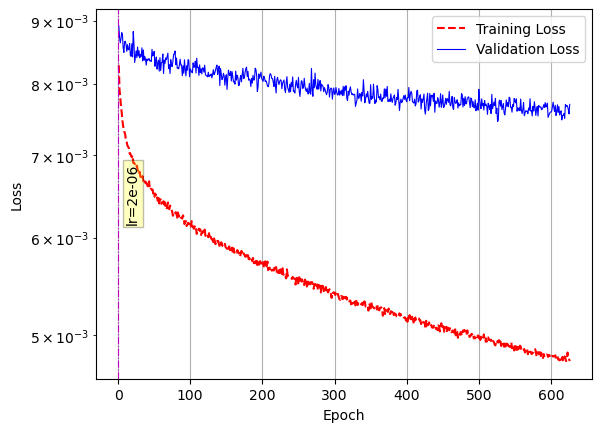

<Figure size 640x480 with 0 Axes>

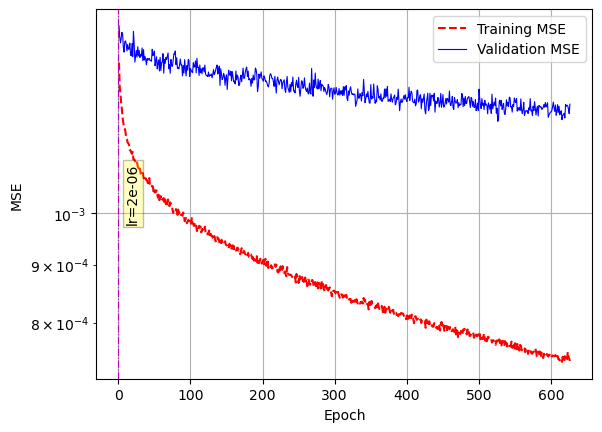

<Figure size 640x480 with 0 Axes>

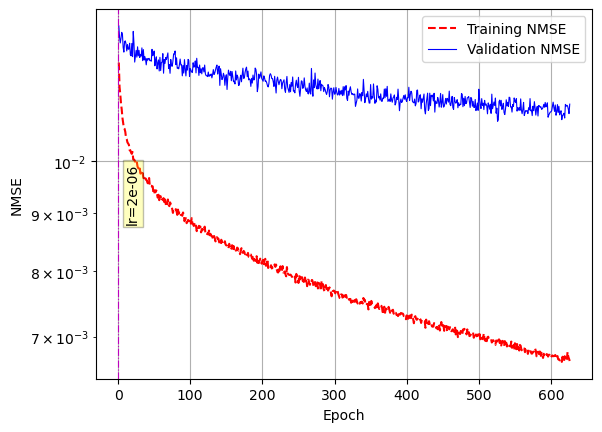

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

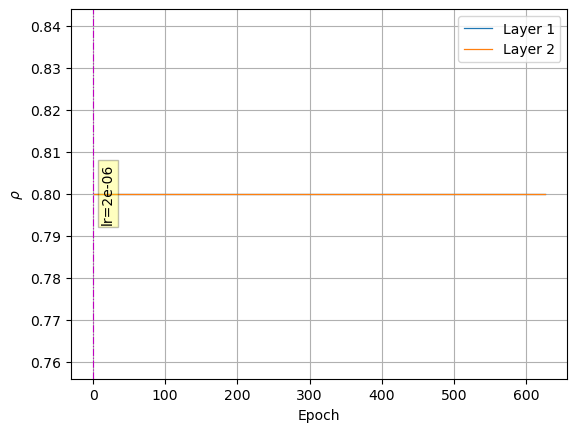

<Figure size 640x480 with 0 Axes>

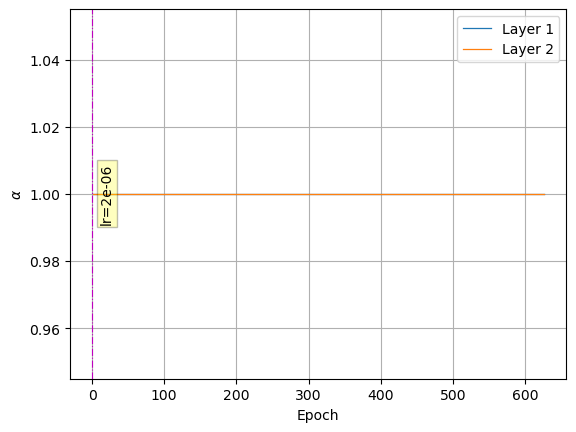

<Figure size 640x480 with 0 Axes>

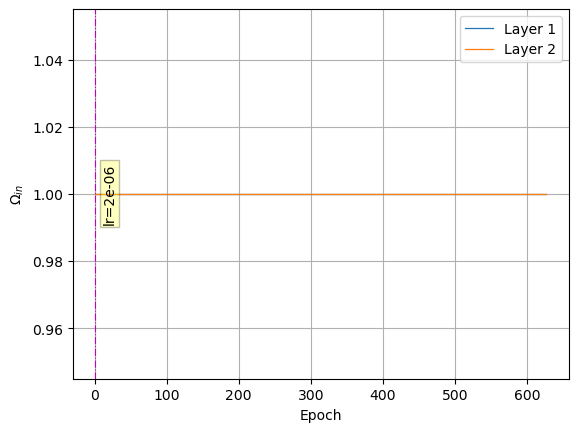



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 1.0


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
49/49 [==============================] - ETA: 0s - loss: 0.0161 - mse: 0.0037 - NMSE: 0.0333 - covmat_fro_loss: 0.0024 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 2m 47.2s

Epoch 1: val_NMSE improved from inf to 0.04052, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/

Epoch 7/1000
49/49 [==============================] - ETA: 0s - loss: 0.0143 - mse: 0.0032 - NMSE: 0.0291 - covmat_fro_loss: 0.0023 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 6m 51.4s

Epoch 7: val_NMSE did not improve from 0.04014
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 833ms/step - loss: 0.0143 - mse: 0.0032 - NMSE: 0.0291 - covmat_fro_loss: 0.0023 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0199 - val_mse: 0.0046 - val_NMSE: 0.0411 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.00

Epoch 14/1000
49/49 [==============================] - ETA: 0s - loss: 0.0136 - mse: 0.0031 - NMSE: 0.0277 - covmat_fro_loss: 0.0023 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 11m 36.9s

Epoch 14: val_NMSE improved from 0.04002 to 0.03921, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 840ms/step - loss: 0.0136 - mse: 0.0031 - NMSE: 0.0277 - covmat_fro_loss: 0.0023 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_

Epoch 21/1000
49/49 [==============================] - ETA: 0s - loss: 0.0132 - mse: 0.0030 - NMSE: 0.0267 - covmat_fro_loss: 0.0022 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 16m 21.6s

Epoch 21: val_NMSE did not improve from 0.03921
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 830ms/step - loss: 0.0132 - mse: 0.0030 - NMSE: 0.0267 - covmat_fro_loss: 0.0022 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0195 - val_mse: 0.0045 - val_NMSE: 0.0402 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 28/1000
49/49 [==============================] - ETA: 0s - loss: 0.0129 - mse: 0.0029 - NMSE: 0.0261 - covmat_fro_loss: 0.0022 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 21m 6.2s

Epoch 28: val_NMSE did not improve from 0.03921
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 831ms/step - loss: 0.0129 - mse: 0.0029 - NMSE: 0.0261 - covmat_fro_loss: 0.0022 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0195 - val_mse: 0.0045 - val_NMSE: 0.0403 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.

Epoch 35/1000
49/49 [==============================] - ETA: 0s - loss: 0.0128 - mse: 0.0029 - NMSE: 0.0257 - covmat_fro_loss: 0.0022 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 25m 51.0s

Epoch 35: val_NMSE did not improve from 0.03921
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 832ms/step - loss: 0.0128 - mse: 0.0029 - NMSE: 0.0257 - covmat_fro_loss: 0.0022 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0198 - val_mse: 0.0045 - val_NMSE: 0.0407 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 42/1000
49/49 [==============================] - ETA: 0s - loss: 0.0125 - mse: 0.0028 - NMSE: 0.0251 - covmat_fro_loss: 0.0022 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 30m 35.2s

Epoch 42: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 40s 822ms/step - loss: 0.0125 - mse: 0.0028 - NMSE: 0.0251 - covmat_fro_loss: 0.0022 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0199 - val_mse: 0.0046 - val_NMSE: 0.0410 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 49/1000
49/49 [==============================] - ETA: 0s - loss: 0.0124 - mse: 0.0028 - NMSE: 0.0248 - covmat_fro_loss: 0.0022 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 35m 19.6s

Epoch 49: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 830ms/step - loss: 0.0124 - mse: 0.0028 - NMSE: 0.0248 - covmat_fro_loss: 0.0022 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0192 - val_mse: 0.0044 - val_NMSE: 0.0396 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 56/1000
49/49 [==============================] - ETA: 0s - loss: 0.0122 - mse: 0.0027 - NMSE: 0.0245 - covmat_fro_loss: 0.0022 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 40m 4.2s

Epoch 56: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 830ms/step - loss: 0.0122 - mse: 0.0027 - NMSE: 0.0245 - covmat_fro_loss: 0.0022 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0191 - val_mse: 0.0044 - val_NMSE: 0.0394 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.

Epoch 63/1000
49/49 [==============================] - ETA: 0s - loss: 0.0120 - mse: 0.0027 - NMSE: 0.0241 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 44m 48.1s

Epoch 63: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 830ms/step - loss: 0.0120 - mse: 0.0027 - NMSE: 0.0241 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0195 - val_mse: 0.0045 - val_NMSE: 0.0401 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 70/1000
49/49 [==============================] - ETA: 0s - loss: 0.0119 - mse: 0.0026 - NMSE: 0.0238 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 49m 32.0s

Epoch 70: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 40s 826ms/step - loss: 0.0119 - mse: 0.0026 - NMSE: 0.0238 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0195 - val_mse: 0.0045 - val_NMSE: 0.0403 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 77/1000
49/49 [==============================] - ETA: 0s - loss: 0.0117 - mse: 0.0026 - NMSE: 0.0234 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 54m 16.2s

Epoch 77: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 829ms/step - loss: 0.0117 - mse: 0.0026 - NMSE: 0.0234 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0197 - val_mse: 0.0045 - val_NMSE: 0.0407 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0

Epoch 84/1000
49/49 [==============================] - ETA: 0s - loss: 0.0117 - mse: 0.0026 - NMSE: 0.0233 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 0h 59m 0.8s

Epoch 84: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 832ms/step - loss: 0.0117 - mse: 0.0026 - NMSE: 0.0233 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0196 - val_mse: 0.0045 - val_NMSE: 0.0404 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.

Epoch 91/1000
49/49 [==============================] - ETA: 0s - loss: 0.0115 - mse: 0.0025 - NMSE: 0.0228 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 3m 46.0s

Epoch 91: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 836ms/step - loss: 0.0115 - mse: 0.0025 - NMSE: 0.0228 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0198 - val_mse: 0.0045 - val_NMSE: 0.0409 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.

Epoch 98/1000
49/49 [==============================] - ETA: 0s - loss: 0.0115 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 8m 30.1s

Epoch 98: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 828ms/step - loss: 0.0115 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0196 - val_mse: 0.0045 - val_NMSE: 0.0405 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.

Epoch 105/1000
49/49 [==============================] - ETA: 0s - loss: 0.0114 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 13m 14.6s

Epoch 105: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 832ms/step - loss: 0.0114 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0202 - val_mse: 0.0046 - val_NMSE: 0.0417 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm:

Epoch 112/1000
49/49 [==============================] - ETA: 0s - loss: 0.0113 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 17m 59.5s

Epoch 112: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 834ms/step - loss: 0.0113 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0195 - val_mse: 0.0045 - val_NMSE: 0.0404 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm:

Epoch 119/1000
49/49 [==============================] - ETA: 0s - loss: 0.0112 - mse: 0.0025 - NMSE: 0.0223 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 22m 44.3s

Epoch 119: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 830ms/step - loss: 0.0112 - mse: 0.0025 - NMSE: 0.0223 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0197 - val_mse: 0.0045 - val_NMSE: 0.0408 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm:

Epoch 126/1000
49/49 [==============================] - ETA: 0s - loss: 0.0111 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 27m 29.0s

Epoch 126: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 830ms/step - loss: 0.0111 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0195 - val_mse: 0.0045 - val_NMSE: 0.0403 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm:

Epoch 133/1000
49/49 [==============================] - ETA: 0s - loss: 0.0111 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 32m 13.1s

Epoch 133: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 832ms/step - loss: 0.0111 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0200 - val_mse: 0.0046 - val_NMSE: 0.0413 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm:

Epoch 140/1000
49/49 [==============================] - ETA: 0s - loss: 0.0111 - mse: 0.0024 - NMSE: 0.0219 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - tot_time: 1h 36m 57.1s

Epoch 140: val_NMSE did not improve from 0.03912
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_022/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 41s 834ms/step - loss: 0.0111 - mse: 0.0024 - NMSE: 0.0219 - covmat_fro_loss: 0.0021 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - rho_res_1: 0.8000 - rho_res_2: 0.8000 - alpha_0: 1.0000 - alpha_1: 1.0000 - alpha_2: 1.0000 - omega_in_0: 1.0000 - omega_in_1: 1.0000 - omega_in_2: 1.0000 - val_loss: 0.0198 - val_mse: 0.0045 - val_NMSE: 0.0408 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm:

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

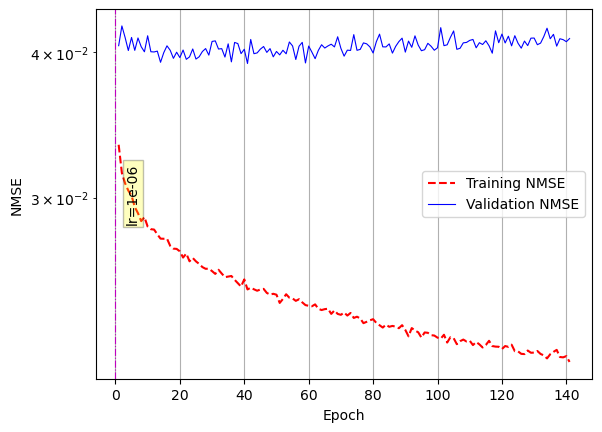

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

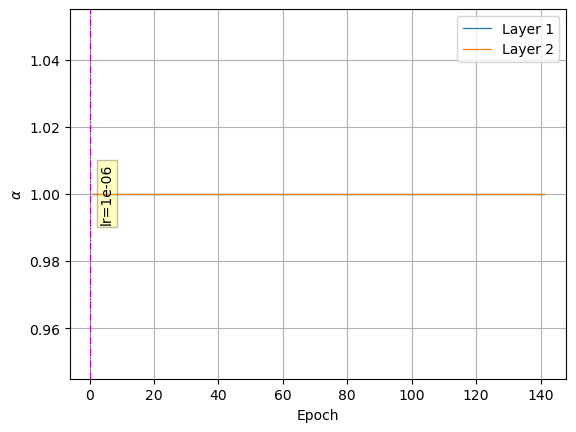

<Figure size 640x480 with 0 Axes>

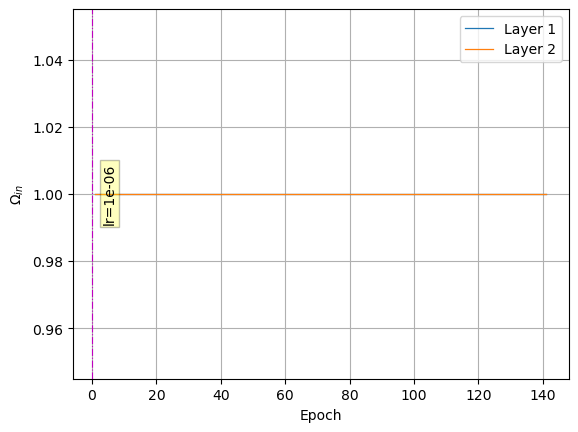

<Figure size 640x480 with 0 Axes>

In [22]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    if behaviour == 'loadCheckpointAndContinueTraining':
        if kk < len(T_sample_output) - 1:
            temp = int((T_sample_output[kk+1] + 0.5*dt_rnn)//dt_rnn)
        else:
            temp = num_outsteps
        checkfile1 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(temp)
        checkfile2 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(temp)
        check1 = os.path.exists(checkfile1)
        check2 = os.path.exists(checkfile2)
        if check1 and check2:
            # move on to checking the next time-step
            continue
        else:
            pass
    
    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_ESN,
        all_data,
        AR_AERNN_ESN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        ESN_flag=True,
        rnn_kwargs=rnn_kwargs,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.25 * np.round(4*global_clipnorm)

In [23]:
### Training the combined AE-RNN


# 